# Data Exploration Turbofan Dataset
Group 2

This data exploration is for each turbine independently, and in the end, we summarize the findings.

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

# If running in google colab set this to True
run_in_colab = False

## 0. Load Data

### For google collab
Just transform it to markdown cells if you run the code offline please

In [2]:
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
if run_in_colab:
    data_dir = '/content/drive/My Drive/Colab Notebooks/' # Change directory according to your setup
    turbine1_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD001.txt', delim_whitespace=True, header=None)
    turbine1_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD001.txt', delim_whitespace=True, header=None)
    turbine2_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD002.txt', delim_whitespace=True, header=None)
    turbine2_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD002.txt', delim_whitespace=True, header=None)
    turbine3_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD003.txt', delim_whitespace=True, header=None)
    turbine3_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD003.txt', delim_whitespace=True, header=None)
    turbine4_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD004.txt', delim_whitespace=True, header=None)
    turbine4_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD004.txt', delim_whitespace=True, header=None)

    turbine1_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD001.txt',sep='\s+', header=None, names=["RUL"])
    turbine2_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD002.txt',sep='\s+', header=None, names=["RUL"])
    turbine3_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD003.txt',sep='\s+', header=None, names=["RUL"])
    turbine4_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD004.txt',sep='\s+', header=None, names=["RUL"])

### For local runtime

In [4]:
if not run_in_colab:
    turbine1_train = pd.read_csv('../data/train_FD001.txt', delim_whitespace=True, header=None)
    turbine1_test = pd.read_csv('../data/test_FD001.txt', delim_whitespace=True, header=None)
    turbine2_train = pd.read_csv('../data/train_FD002.txt', delim_whitespace=True, header=None)
    turbine2_test = pd.read_csv('../data/test_FD002.txt', delim_whitespace=True, header=None)
    turbine3_train = pd.read_csv('../data/train_FD003.txt', delim_whitespace=True, header=None)
    turbine3_test = pd.read_csv('../data/test_FD003.txt', delim_whitespace=True, header=None)
    turbine4_train = pd.read_csv('../data/train_FD004.txt', delim_whitespace=True, header=None)
    turbine4_test = pd.read_csv('../data/test_FD004.txt', delim_whitespace=True, header=None)

    turbine1_rul_test = pd.read_csv('../data/RUL_FD001.txt',sep='\s+', header=None, names=["RUL"])
    turbine2_rul_test = pd.read_csv('../data/RUL_FD002.txt',sep='\s+', header=None, names=["RUL"])
    turbine3_rul_test = pd.read_csv('../data/RUL_FD003.txt',sep='\s+', header=None, names=["RUL"])
    turbine4_rul_test = pd.read_csv('../data/RUL_FD004.txt',sep='\s+', header=None, names=["RUL"])

In [5]:
# Define column names
index_columns_names =  ["unit_number","cycle"]
operational_settings_columns_names = ["operational_setting_"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["sensor_measure_"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [6]:
# Sensor dictionairy from corresponding paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4711414
sensor_dict={}
dict_list=[ "(Total temperature at fan inlet) (◦R)",
"(Total temperature at LPC outlet) (◦R)",
"(Total temperature at HPC outlet) (◦R)",
"(Total temperature at LPT outlet) (◦R)",
"(Pressure at fan inlet) (psia)",
"(Total pressure in bypass-duct) (psia)",
"(Total pressure at HPC outlet) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(Static pressure at HPC outlet) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Demanded fan speed) (rpm)",
"(Demanded corrected fan speed) (rpm)",
"(HPT coolant bleed) (lbm/s)",
"(LPT coolant bleed) (lbm/s)" ]
i=1
for x in dict_list :
    sensor_dict['sensor_measure_'+str(i)]=x
    i+=1
sensor_dict

{'sensor_measure_1': '(Total temperature at fan inlet) (◦R)',
 'sensor_measure_2': '(Total temperature at LPC outlet) (◦R)',
 'sensor_measure_3': '(Total temperature at HPC outlet) (◦R)',
 'sensor_measure_4': '(Total temperature at LPT outlet) (◦R)',
 'sensor_measure_5': '(Pressure at fan inlet) (psia)',
 'sensor_measure_6': '(Total pressure in bypass-duct) (psia)',
 'sensor_measure_7': '(Total pressure at HPC outlet) (psia)',
 'sensor_measure_8': '(Physical fan speed) (rpm)',
 'sensor_measure_9': '(Physical core speed) (rpm)',
 'sensor_measure_10': '(Engine pressure ratio(P50/P2)',
 'sensor_measure_11': '(Static pressure at HPC outlet) (psia)',
 'sensor_measure_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'sensor_measure_13': '(Corrected fan speed) (rpm)',
 'sensor_measure_14': '(Corrected core speed) (rpm)',
 'sensor_measure_15': '(Bypass Ratio) ',
 'sensor_measure_16': '(Burner fuel-air ratio)',
 'sensor_measure_17': '(Bleed Enthalpy)',
 'sensor_measure_18': '(Demanded fan speed

In [7]:
turbine1_train.columns = input_file_column_names
turbine1_test.columns = input_file_column_names
turbine2_train.columns = input_file_column_names
turbine2_test.columns = input_file_column_names
turbine3_train.columns = input_file_column_names
turbine3_test.columns = input_file_column_names
turbine4_train.columns = input_file_column_names
turbine4_test.columns = input_file_column_names

In [8]:
# Add RUL column to the dataframes
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["cycle"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    result_frame.drop("max_cycle", axis=1, inplace=True)
    return result_frame

#Only for train data. Test data we dont have max_cycle
turbine1_train = add_remaining_useful_life(turbine1_train)
turbine2_train = add_remaining_useful_life(turbine2_train)
turbine3_train = add_remaining_useful_life(turbine3_train)
turbine4_train = add_remaining_useful_life(turbine4_train)

### 0.1 Usefull functions

In [9]:
def save_plot(fig, filename):
    fig.savefig(filename, format='svg')

def plot_feature_distributuon(df):
    # Calculate the number of rows needed
    columns = df.drop(['unit_number', 'cycle'], axis=1).columns
    num_rows = len(columns) // 4
    if len(columns) % 4 != 0:
        num_rows += 1

    fig, axes = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))
    axes = axes.flatten()

    # Plot histograms for each sensor
    for i, feature in enumerate(columns):
        ax = axes[i]
        sns.histplot(df[feature], kde=True, color='blue', label='Train', ax=ax)
        if feature != 'RUL':
            sns.histplot(turbine1_test[feature], kde=True, color='orange', label='Test', ax=ax)
        ax.set_title(feature)
        ax.legend()

    # Hide empty subplots
    for i in range(len(columns), num_rows * 4):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    return fig

def count_train_test_cycle(train, test, bins=20):
    grouped_by_unit_train = train.groupby(by="unit_number")
    grouped_by_unit_test = test.groupby(by="unit_number")
    max_cycle_train = grouped_by_unit_train["cycle"].max()
    max_cycle_test = grouped_by_unit_test["cycle"].max()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=max_cycle_train, binwidth=bins, kde=True, color='blue', label='Train')
    sns.histplot(data=max_cycle_test, binwidth=bins, kde=True, color='orange', label='Test')

    # Adding x and y labels
    plt.xlabel("Max cycles of motors")  # Adding x label
    plt.ylabel("Frequency")             # Adding y label

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()

    # Print max and min cycles
    print('-'*30)
    print("Maximum life cycle in the training set is :", max_cycle_train.max())
    print("Minimum life cycle in the training set is :", max_cycle_train.min())
    print('-'*30)
    print("Maximum life cycle in the test set is :", max_cycle_test.max())
    print("Minimum life cycle in the test set is :", max_cycle_test.min())
    return fig

def pearson_correlation_plot(df):
    # Pearson correlation heatmap
    corr = df.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(15,12))
    sns.heatmap(corr, cmap='coolwarm', linewidths=.5)
    return fig


def highly_correlated_values(df):
    corr = df.corr(method='pearson')
    # Print highly correlated values
    analysis_data_corr2 = pd.DataFrame(np.tril(corr.values), columns=corr.columns, index = corr.index)

    correlating = []
    for col in analysis_data_corr2.columns:
        ser = analysis_data_corr2[col]
        idx = np.logical_or(-0.8 > ser,  ser > 0.8)
        for i, c in zip(ser[idx].index, ser[idx].values):
            if (i, col, c) not in correlating and i != col:
                correlating.append((col, i, c))

    print('Highly correlating values:')
    for c in correlating:
        print(c)

    print('Number of highly correlating values:', len(correlating))

## 1. Data Exploration

### 1.1 Turbine 1

#### 1.1.1 Data inspection

In [10]:
print("Training Data Rows {}, Columns {}".format(turbine1_train.shape[0], turbine1_train.shape[1]))
print("Test Data Rows {}, Columns {}".format(turbine1_test.shape[0], turbine1_test.shape[1]))
turbine1_train.head()

Training Data Rows 20631, Columns 27
Test Data Rows 13096, Columns 26


unit_number  cycle  operational_setting_1  operational_setting_2  operational_setting_3  \
0            1      1                -0.0007                -0.0004                  100.0   
1            1      2                 0.0019                -0.0003                  100.0   
2            1      3                -0.0043                 0.0003                  100.0   
3            1      4                 0.0007                 0.0000                  100.0   
4            1      5                -0.0019                -0.0002                  100.0   

   sensor_measure_1  sensor_measure_2  sensor_measure_3  sensor_measure_4  sensor_measure_5  \
0            518.67            641.82           1589.70           1400.60             14.62   
1            518.67            642.15           1591.82           1403.14             14.62   
2            518.67            642.35           1587.99           1404.20             14.62   
3            518.67            642.35           1582.79           1401.87             14.62   
4            518.67            642.37           1582.85           1406.22             14.62   

   sensor_measure_6  sensor_measure_7  sensor_measure_8  sensor_measure_9  sensor_measure_10  \
0             21.61            554.36           2388.06           9046.19                1.3   
1             21.61            553.75           2388.04           9044.07                1.3   
2             21.61            554.26           2388.08           9052.94                1.3   
3             21.61            554.45           2388.11           9049.48                1.3   
4             21.61            554.00           2388.06           9055.15                1.3   

   sensor_measure_11  sensor_measure_12  sensor_measure_13  sensor_measure_14  sensor_measure_15  \
0              47.47             521.66            2388.02            8138.62             8.4195   
1              47.49             522.28            2388.07            8131.49             8.4318   
2              47.27             522.42            2388.03            8133.23             8.4178   
3              47.13             522.86            2388.08            8133.83             8.3682   
4              47.28             522.19            2388.04            8133.80             8.4294   

   sensor_measure_16  sensor_measure_17  sensor_measure_18  sensor_measure_19  sensor_measure_20  \
0               0.03                392               2388              100.0              39.06   
1               0.03                392               2388              100.0              39.00   
2               0.03                390               2388              100.0              38.95   
3               0.03                392               2388              100.0              38.88   
4               0.03                393               2388              100.0              38.90   

   sensor_measure_21  RUL  
0            23.4190  191  
1            23.4236  190  
2            23.3442  189  
3            23.3739  188  
4            23.4044  187

In [11]:
print("Test Data Rows {}, Columns {}".format(turbine1_test.shape[0], turbine1_test.shape[1]))
turbine1_test.head()

Test Data Rows 13096, Columns 26


unit_number  cycle  operational_setting_1  operational_setting_2  operational_setting_3  \
0            1      1                 0.0023                 0.0003                  100.0   
1            1      2                -0.0027                -0.0003                  100.0   
2            1      3                 0.0003                 0.0001                  100.0   
3            1      4                 0.0042                 0.0000                  100.0   
4            1      5                 0.0014                 0.0000                  100.0   

   sensor_measure_1  sensor_measure_2  sensor_measure_3  sensor_measure_4  sensor_measure_5  \
0            518.67            643.02           1585.29           1398.21             14.62   
1            518.67            641.71           1588.45           1395.42             14.62   
2            518.67            642.46           1586.94           1401.34             14.62   
3            518.67            642.44           1584.12           1406.42             14.62   
4            518.67            642.51           1587.19           1401.92             14.62   

   sensor_measure_6  sensor_measure_7  sensor_measure_8  sensor_measure_9  sensor_measure_10  \
0             21.61            553.90           2388.04           9050.17                1.3   
1             21.61            554.85           2388.01           9054.42                1.3   
2             21.61            554.11           2388.05           9056.96                1.3   
3             21.61            554.07           2388.03           9045.29                1.3   
4             21.61            554.16           2388.01           9044.55                1.3   

   sensor_measure_11  sensor_measure_12  sensor_measure_13  sensor_measure_14  sensor_measure_15  \
0              47.20             521.72            2388.03            8125.55             8.4052   
1              47.50             522.16            2388.06            8139.62             8.3803   
2              47.50             521.97            2388.03            8130.10             8.4441   
3              47.28             521.38            2388.05            8132.90             8.3917   
4              47.31             522.15            2388.03            8129.54             8.4031   

   sensor_measure_16  sensor_measure_17  sensor_measure_18  sensor_measure_19  sensor_measure_20  \
0               0.03                392               2388              100.0              38.86   
1               0.03                393               2388              100.0              39.02   
2               0.03                393               2388              100.0              39.08   
3               0.03                391               2388              100.0              39.00   
4               0.03                390               2388              100.0              38.99   

   sensor_measure_21  
0            23.3735  
1            23.3916  
2            23.4166  
3            23.3737  
4            23.4130

In [12]:
units = turbine1_train["unit_number"].unique()
print("The training data contains {} turbofan motors.".format(len(units)))

units = turbine1_test["unit_number"].unique()
print("The test data contains {} turbofan motors.".format(len(units)))

The training data contains 100 turbofan motors.
The test data contains 100 turbofan motors.


In [13]:
print("Y test shape: ", turbine1_rul_test.shape)

Y test shape:  (100, 1)


In [14]:
# Check  missing values
turbine1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            20631 non-null  int64  
 1   cycle                  20631 non-null  int64  
 2   operational_setting_1  20631 non-null  float64
 3   operational_setting_2  20631 non-null  float64
 4   operational_setting_3  20631 non-null  float64
 5   sensor_measure_1       20631 non-null  float64
 6   sensor_measure_2       20631 non-null  float64
 7   sensor_measure_3       20631 non-null  float64
 8   sensor_measure_4       20631 non-null  float64
 9   sensor_measure_5       20631 non-null  float64
 10  sensor_measure_6       20631 non-null  float64
 11  sensor_measure_7       20631 non-null  float64
 12  sensor_measure_8       20631 non-null  float64
 13  sensor_measure_9       20631 non-null  float64
 14  sensor_measure_10      20631 non-null  float64
 15  se

In [15]:
turbine1_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            13096 non-null  int64  
 1   cycle                  13096 non-null  int64  
 2   operational_setting_1  13096 non-null  float64
 3   operational_setting_2  13096 non-null  float64
 4   operational_setting_3  13096 non-null  float64
 5   sensor_measure_1       13096 non-null  float64
 6   sensor_measure_2       13096 non-null  float64
 7   sensor_measure_3       13096 non-null  float64
 8   sensor_measure_4       13096 non-null  float64
 9   sensor_measure_5       13096 non-null  float64
 10  sensor_measure_6       13096 non-null  float64
 11  sensor_measure_7       13096 non-null  float64
 12  sensor_measure_8       13096 non-null  float64
 13  sensor_measure_9       13096 non-null  float64
 14  sensor_measure_10      13096 non-null  float64
 15  se

All values are numeric and there are no missing values.

In [16]:
# Check if there are missing cycles in any unit
grouped = turbine1_train.groupby('unit_number')
missing_cycles = []
for unit, group in grouped:
    # Check if all cycles from 1 to max cycle number exist
    if not all(cycle in group['cycle'].values for cycle in range(1, group['cycle'].max() + 1)):
        missing_cycles.append(unit)
print("Number of missing cycles: " ,missing_cycles)

Number of missing cycles:  []


In [17]:
# Statistics summary
turbine1_train.describe(include='all')

unit_number         cycle  operational_setting_1  operational_setting_2  \
count  20631.000000  20631.000000           20631.000000           20631.000000   
mean      51.506568    108.807862              -0.000009               0.000002   
std       29.227633     68.880990               0.002187               0.000293   
min        1.000000      1.000000              -0.008700              -0.000600   
25%       26.000000     52.000000              -0.001500              -0.000200   
50%       52.000000    104.000000               0.000000               0.000000   
75%       77.000000    156.000000               0.001500               0.000300   
max      100.000000    362.000000               0.008700               0.000600   

       operational_setting_3  sensor_measure_1  sensor_measure_2  sensor_measure_3  \
count                20631.0      2.063100e+04      20631.000000      20631.000000   
mean                   100.0      5.186700e+02        642.680934       1590.523119   
std                      0.0      6.537152e-11          0.500053          6.131150   
min                    100.0      5.186700e+02        641.210000       1571.040000   
25%                    100.0      5.186700e+02        642.325000       1586.260000   
50%                    100.0      5.186700e+02        642.640000       1590.100000   
75%                    100.0      5.186700e+02        643.000000       1594.380000   
max                    100.0      5.186700e+02        644.530000       1616.910000   

       sensor_measure_4  sensor_measure_5  sensor_measure_6  sensor_measure_7  sensor_measure_8  \
count      20631.000000      2.063100e+04      20631.000000      20631.000000      20631.000000   
mean        1408.933782      1.462000e+01         21.609803        553.367711       2388.096652   
std            9.000605      3.394700e-12          0.001389          0.885092          0.070985   
min         1382.250000      1.462000e+01         21.600000        549.850000       2387.900000   
25%         1402.360000      1.462000e+01         21.610000        552.810000       2388.050000   
50%         1408.040000      1.462000e+01         21.610000        553.440000       2388.090000   
75%         1414.555000      1.462000e+01         21.610000        554.010000       2388.140000   
max         1441.490000      1.462000e+01         21.610000        556.060000       2388.560000   

       sensor_measure_9  sensor_measure_10  sensor_measure_11  sensor_measure_12  \
count      20631.000000       2.063100e+04       20631.000000       20631.000000   
mean        9065.242941       1.300000e+00          47.541168         521.413470   
std           22.082880       4.660829e-13           0.267087           0.737553   
min         9021.730000       1.300000e+00          46.850000         518.690000   
25%         9053.100000       1.300000e+00          47.350000         520.960000   
50%         9060.660000       1.300000e+00          47.510000         521.480000   
75%         9069.420000       1.300000e+00          47.700000         521.950000   
max         9244.590000       1.300000e+00          48.530000         523.380000   

       sensor_measure_13  sensor_measure_14  sensor_measure_15  sensor_measure_16  \
count       20631.000000       20631.000000       20631.000000       2.063100e+04   
mean         2388.096152        8143.752722           8.442146       3.000000e-02   
std             0.071919          19.076176           0.037505       1.556432e-14   
min          2387.880000        8099.940000           8.324900       3.000000e-02   
25%          2388.040000        8133.245000           8.414900       3.000000e-02   
50%          2388.090000        8140.540000           8.438900       3.000000e-02   
75%          2388.140000        8148.310000           8.465600       3.000000e-02   
max          2388.560000        8293.720000           8.584800       3.000000e-02   

       sensor_measure_17  sensor_measure_18  sensor_measure_19  sensor

In [18]:
turbine1_test.describe(include='all')

unit_number         cycle  operational_setting_1  operational_setting_2  \
count  13096.000000  13096.000000           13096.000000           13096.000000   
mean      51.543907     76.836515              -0.000011               0.000004   
std       28.289423     53.057749               0.002203               0.000294   
min        1.000000      1.000000              -0.008200              -0.000600   
25%       28.000000     33.000000              -0.001500              -0.000200   
50%       52.000000     69.000000              -0.000000              -0.000000   
75%       76.000000    113.000000               0.001500               0.000300   
max      100.000000    303.000000               0.007800               0.000700   

       operational_setting_3  sensor_measure_1  sensor_measure_2  sensor_measure_3  \
count                13096.0      1.309600e+04      13096.000000      13096.000000   
mean                   100.0      5.186700e+02        642.475088       1588.099204   
std                      0.0      6.014263e-11          0.400899          5.003274   
min                    100.0      5.186700e+02        641.130000       1569.040000   
25%                    100.0      5.186700e+02        642.197500       1584.600000   
50%                    100.0      5.186700e+02        642.460000       1587.990000   
75%                    100.0      5.186700e+02        642.740000       1591.362500   
max                    100.0      5.186700e+02        644.300000       1607.550000   

       sensor_measure_4  sensor_measure_5  sensor_measure_6  sensor_measure_7  sensor_measure_8  \
count      13096.000000      1.309600e+04      13096.000000      13096.000000      13096.000000   
mean        1404.735362      1.462000e+01         21.609701        553.757523       2388.070964   
std            6.688309      2.671743e-12          0.001704          0.681286          0.057442   
min         1384.390000      1.462000e+01         21.600000        550.880000       2387.890000   
25%         1399.950000      1.462000e+01         21.610000        553.310000       2388.030000   
50%         1404.440000      1.462000e+01         21.610000        553.800000       2388.070000   
75%         1409.050000      1.462000e+01         21.610000        554.240000       2388.110000   
max         1433.360000      1.462000e+01         21.610000        555.840000       2388.300000   

       sensor_measure_9  sensor_measure_10  sensor_measure_11  sensor_measure_12  \
count      13096.000000       1.309600e+04       13096.000000       13096.000000   
mean        9058.407363       1.300000e+00          47.416204         521.747724   
std           11.436261       3.157595e-13           0.195917           0.559627   
min         9024.530000       1.300000e+00          46.800000         519.380000   
25%         9051.020000       1.300000e+00          47.270000         521.380000   
50%         9057.320000       1.300000e+00          47.410000         521.780000   
75%         9064.110000       1.300000e+00          47.540000         522.150000   
max         9155.030000       1.300000e+00          48.260000         523.760000   

       sensor_measure_13  sensor_measure_14  sensor_measure_15  sensor_measure_16  \
count       13096.000000       13096.000000       13096.000000       1.309600e+04   
mean         2388.071025        8138.947817           8.425844       3.000000e-02   
std             0.056934          10.188605           0.029009       8.823140e-15   
min          2387.890000        8108.500000           8.332800       3.000000e-02   
25%          2388.030000        8132.310000           8.405600       3.000000e-02   
50%          2388.070000        8138.390000           8.424900       3.000000e-02   
75%          2388.110000        8144.360000           8.444300       3.000000e-02   
max          2388.320000        8220.480000           8.541400       3.000000e-02   

       sensor_measure_17  sensor_measure_18  sensor_measure_19  sensor

#### 1.1.2 Feauture distribution

In [9]:
# Search for constant columns
constant_columns = turbine1_train.columns[turbine1_train.nunique() == 1]

# Display constant value columns
constant_value_df = turbine1_train[constant_columns]
print("Constant value columns:")
print(constant_value_df)

Constant value columns:
       operational_setting_3  sensor_measure_1  sensor_measure_5  sensor_measure_10  \
0                      100.0            518.67             14.62                1.3   
1                      100.0            518.67             14.62                1.3   
2                      100.0            518.67             14.62                1.3   
3                      100.0            518.67             14.62                1.3   
4                      100.0            518.67             14.62                1.3   
...                      ...               ...               ...                ...   
20626                  100.0            518.67             14.62                1.3   
20627                  100.0            518.67             14.62                1.3   
20628                  100.0            518.67             14.62                1.3   
20629                  100.0            518.67             14.62                1.3   
20630              

The column setting_3, sensor_1, sensor_5, sensor_16,  sensor_10, sensor_18, and sensor_19 in  only contain a constant value both the training and test set and therefore add no information to the prediction.

Moreover, the sensor_6 value exhibits a low std of 0.001389 which shows that there is minimal variability and that the value is mostly constant except for a few outliers. This is confirmed when observing the box plot and sensor signal plots below. Therefore, these sensor values can be dropped.

In [10]:
columns_to_remove = ['operational_setting_3',  'sensor_measure_1', 'sensor_measure_5', 'sensor_measure_6', 'sensor_measure_10','sensor_measure_16', 'sensor_measure_18', 'sensor_measure_19']
turbine1_train =turbine1_train.drop(columns_to_remove, axis=1)
turbine1_test = turbine1_test.drop(columns_to_remove, axis=1)
sensor_names = [s for s in sensor_measure_columns_names if s not in columns_to_remove]

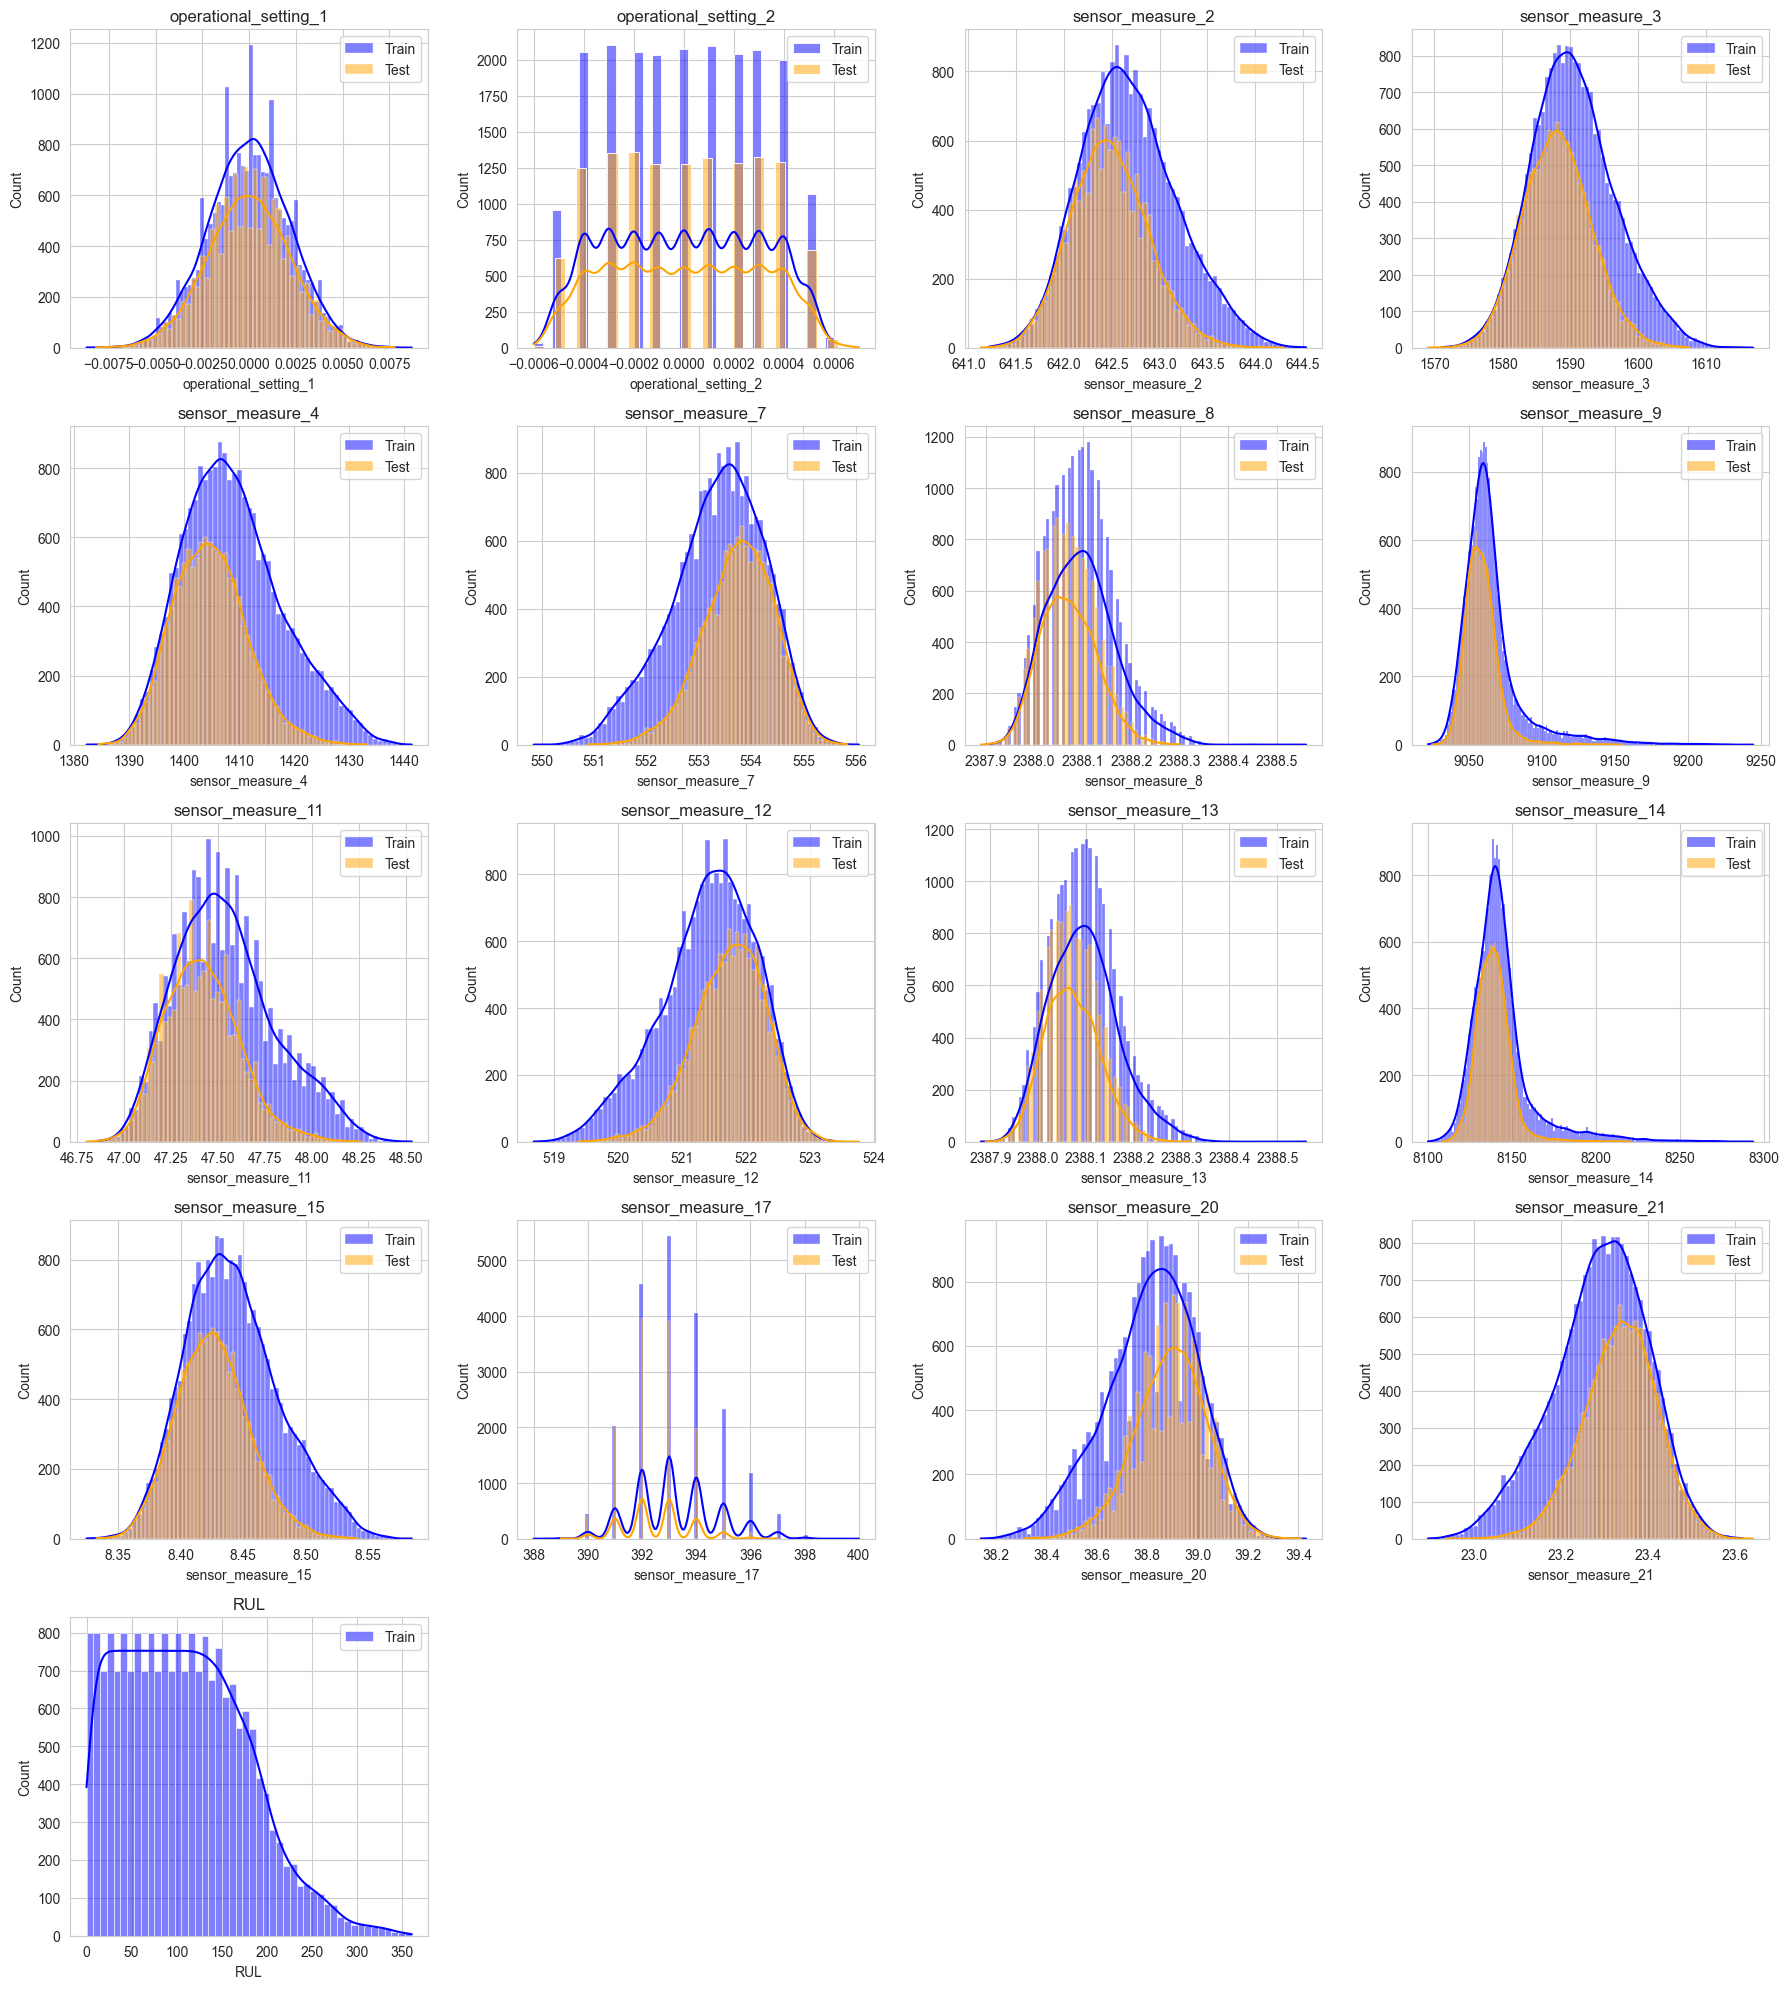

In [33]:
plot_feature_distributuon(turbine1_train)

Almost all variables follow a  gaussian distribution which is slightly skewed, except sensor_17 and setting_2.

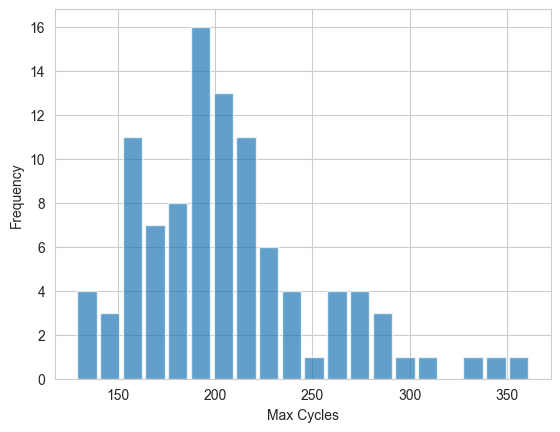

In [51]:
grouped_by_unit = turbine1_train.groupby(by="unit_number")
max_cycle = grouped_by_unit["cycle"].max()
plt.hist(x=max_cycle, bins=20, alpha=0.7, rwidth=0.85);
plt.xlabel('Max Cycles')
plt.ylabel('Frequency');

In [52]:
print("Maximum life cycle in the training set is :", max_cycle.max())
print("Minimum life cycle in the training set is :", max_cycle.min())

Maximum life cycle in the training set is : 362
Minimum life cycle in the training set is : 128


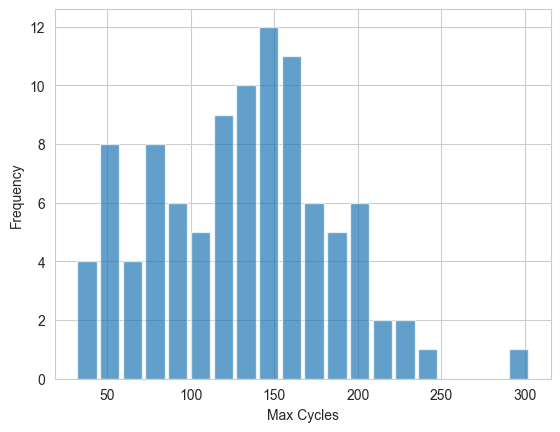

In [53]:
grouped_by_unit = turbine1_test.groupby(by="unit_number")
max_cycle = grouped_by_unit["cycle"].max()
plt.hist(x=max_cycle, bins=20,alpha=0.7, rwidth=0.85);
plt.xlabel('Max Cycles')
plt.ylabel('Frequency');

In [15]:
print("Maximum cycle number in the test set is :", max_cycle.max())
print("Minimum cycle number in the test set is :", max_cycle.min())

Maximum cycle number in the test set is : 303
Minimum cycle number in the test set is : 31


**The sliding window size should be smaller than 31 for this dataset**

#### 1.1.3 Correlation

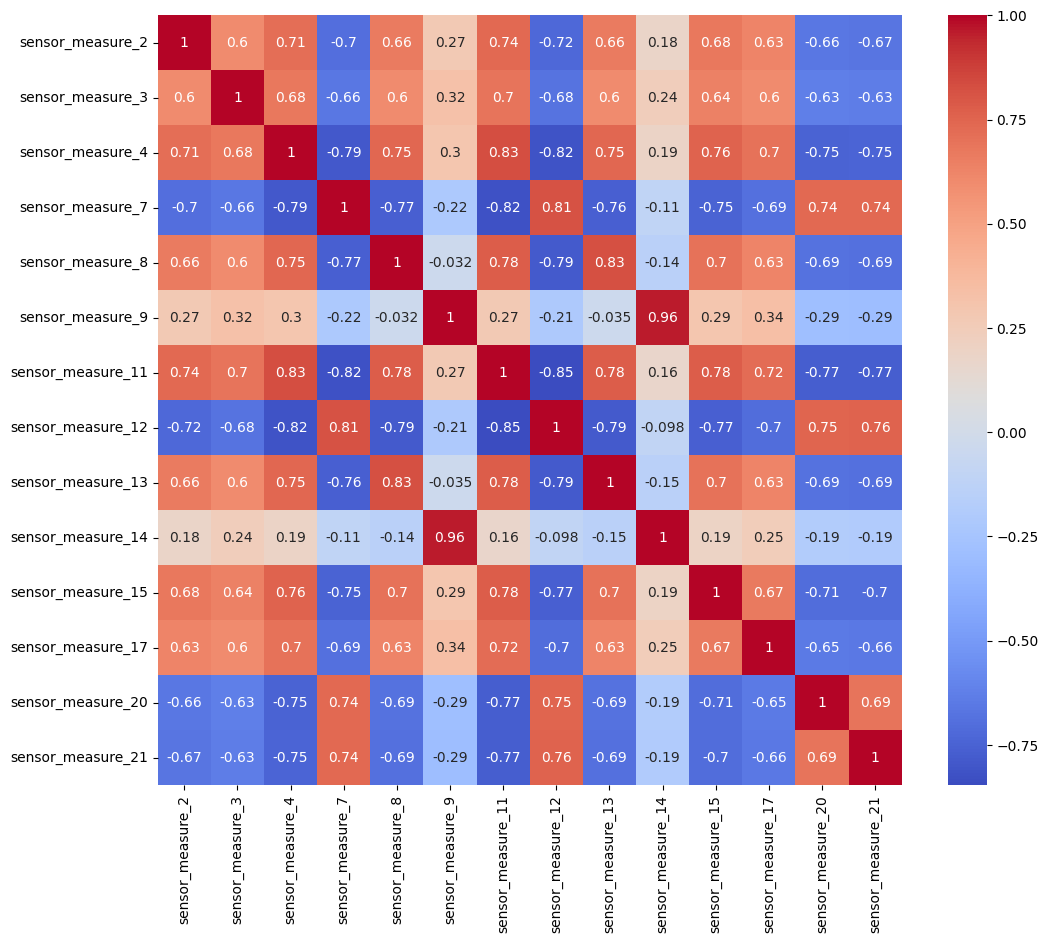

In [16]:
plt.figure(figsize=(12,10))
corr = turbine1_train[sensor_names].corr()
sns.heatmap(corr,annot=True, cmap = 'coolwarm')
plt.show()

Some sensor values are highly correlated with each other.

In [ ]:
def get_high_correlation_pairs(corr_matrix, threshold=0.8):
    # Get the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature pairs with correlation greater than the threshold
    high_corr_pairs = [(sensor1, sensor2, corr_matrix.loc[sensor1, sensor2])
                       for sensor1 in upper.columns for sensor2 in upper.index
                       if abs(upper.loc[sensor1, sensor2]) > threshold]

    return high_corr_pairs

# Get the high correlation pairs
high_corr_pairs = get_high_correlation_pairs(corr, threshold=0.8)

# Output the list of high correlation pairs
print("High correlation pairs (correlation > 0.8):")
for sensor1, sensor2, corr_value in high_corr_pairs:
    print(f"{sensor1} {sensor_dict[sensor1]} and {sensor2} {sensor_dict[sensor2]}: {corr_value:.2f}")

In [ ]:
# Correlation to RUL
turbine1_train.corr()['RUL'].sort_values(ascending=False)

- Strong positive correlation (>= 0.5): sensor_12, sensor_7, sensor_21, sensor_20
- Strong negative correlation (<= -0,5) : sensor_13, sensor_3, sensor_8, sensor_17, sensor_2, sensor_15, sensor_4, sensor_11
- weak correlation (abs value y< 0.5):  unit_number, setting_2, setting_1, sensor_14, sensor_9 have a weak correlation

In [ ]:
# Correlation to settings
turbine1_train.corr()['operational_setting_1'].sort_values(ascending=False)

In [ ]:
turbine1_train.corr()['operational_setting_2'].sort_values(ascending=False)

There seems to be no strong correlation of sensor values or RUL to the settings

#### 1.1.4 Correlation for a single motor

In [ ]:
# Compare with single motor unit
plt.figure(figsize=(12,10))
unit_id = 2
unit_df = turbine1_train[turbine1_train['unit_number'] == unit_id]
# Calculate the correlation matrix for a single unit
corr_unit = unit_df[sensor_names].corr()
sns.heatmap(corr_unit,annot=True, cmap = 'coolwarm')
plt.show()

In [ ]:
unit_df.corr()['RUL'].sort_values(ascending=False)

In [ ]:
# Get the high correlation pairs
high_corr_pairs = get_high_correlation_pairs(corr_unit, threshold=0.8)

# Output the list of high correlation pairs
print("High correlation pairs (correlation > 0.8):")
for sensor1, sensor2, corr_value in high_corr_pairs:
    print(f"{sensor1} and {sensor2}: {corr_value:.2f}")

The pairwise correlation of different sensors seems to be different when looking at different motor units

#### 1.1.5 Time and Distributions Plots

In [ ]:
def plot_features(df, feature_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_number
            plt.plot('RUL', feature_name,
                     data=df[df['unit_number']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(feature_name)
    plt.xlabel('RUL')


    plt.show()

In [ ]:
plot_features(turbine1_train, 'operational_setting_1')
plot_features(turbine1_train, 'operational_setting_2')

The sensor settings show no trend  but seem to flucutate between  the same a minimum and maximum value for all units, maybe due to noise.

In [ ]:
for sensor_name in sensor_names:
    plot_features(turbine1_train, sensor_name)

The minimum max_cycle (operating time) is 128. When passing this threshold, the sensor show a strong trend toward end of lifetime and therefore a correlation to RUL.

Mostly it's either an increasing or decreasing trends. For sensor_14 and sensor_9 the type  and strength of trend depends on the motor unit. Notable is that they also had the highest pairwise correlation. Removing variables that do now show a single trend (sensor_14, sensor_9 and settings) could therefore be considered as candidates for removal.

In [ ]:
# Calculate the number of rows needed
num_rows = len(sensor_names) // 3
if len(sensor_names) % 3 != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 3, figsize=(16, 5 * num_rows))
axes = axes.flatten()

# Plot each sensor's boxplot for both train and test datasets
for i, sensor in enumerate(sensor_names):
    ax = axes[i]
    ax.boxplot([turbine1_train[sensor], turbine1_test[sensor]], labels=['Train', 'Test'])
    ax.set_title(sensor)
    ax.set_xticklabels(['Train', 'Test'])

# Hide empty subplots
for i in range(len(sensor_names), num_rows * 3):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### 1.1.6 Stationary

Stationarity means that statistical features such as mean, variance, and correlation remain consistent over time and are not time-dependent. Some models assume stationarity of data, therefore it is important to check stationarity. This  involves examining trends, seasonality, and other patterns in the time series data. This can be done e.g. by examining the plots.
- Trends: increasing or decreasing values
- seasonality: repeating short-term cycle

Another way to stastically test is the Augmented Dickey-Fuller test which is called a unit root test.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

https://himani-gulati.medium.com/time-series-analysis-data-exploration-and-visualization-9dbede5cbb8d

If data is found to be non-stationary, it may require preprocessing steps such as differencing or detrending to achieve stationarity.  This ensures that the time series data is in a suitable form for accurate autocorrelation assessment. Also some models assume stationarity in data (e.g. ARIMA, SARIMA) while others don't require stationarity (e.g. Random Forest, Regression, Gradient Boost, and Neural Networks.
- Differencing: Subtracting the previous value from the current value to remove trends.
- Detrending: Removing trends using regression techniques.

**However, for predicting  the RUL the trend is a key feature, so differencing removes essential information.**

In [ ]:
# Create an empty DataFrame to store ADF test results
adf_results = None

# Group data by 'unit_number'
grouped = turbine1_train.groupby('unit_number')

# Iterate over each group (unit)
for unit, data in grouped:
    # Iterate over each sensor column
    for sensor_col in sensor_names:
        # Perform ADF test for the sensor time series
        adf_statistic, p_value, _, _, critical_values, _ = adfuller(data[sensor_col])
        # Store ADF test results in the DataFrame
        new_df = pd.DataFrame({'Unit': unit, 'Sensor': sensor_col,  'ADF Statistic':  adf_statistic, 'p-value': p_value,  'Critical Value 1%': critical_values['1%'],  'Critical Value 5%': critical_values['5%'],  'Critical Value 10%': critical_values['10%'] }, index=[0])
        adf_results = new_df if adf_results is None else pd.concat([adf_results, new_df], ignore_index=True)

# Print or display the DataFrame
adf_results

In [ ]:
(adf_results['p-value'] <= 0.05).sum()

46 of 1400 time series are stationary, so most of them are non-stationary.

#### 1.1.7 Difference

In [ ]:
for sensor in sensor_names:
    turbine1_train[sensor + '_diff'] = turbine1_train[sensor] - turbine1_train[sensor].shift(1) # same as turbine1_train[sensor + '_diff'] = turbine1_train[sensor].diff()?
turbine1_train.dropna(inplace=True)  # Drop NaN values introduced by differencing
turbine1_train.head()

In [ ]:
for sensor_name in sensor_names:
        plot_features(turbine1_train, sensor_name + '_diff')

#### 1.1.8 Autocorrelation

Auto-correlation measures the correlation between a time series and its lagged values (previous time steps), revealing how each observation in the series is related to its past observation.
Partial Autocorellation  measures the correlation between a time series and specific lagged values without taking effect of intermediate lags into account.
Both provide insights into the underlying structure of the data and help identify potential patterns and relationships, which helps to select the right model.
between an observation and its previous observations at a specific lag, excluding the contributions from intermediate lags.
In the plots the spikes indicate the degree of correlation between the time series and its lagged values
- Look for significant spikes outside the blue confidence intervals (autocorrelation is unlikely to be due to random noise)
- ACF plot: identify patterns (slow decay suggests non-stationarity, cutoff suggests stationarity)
- PACF plot:  cut-off pattern can help determine the order of an autoregressive (AR) process (sharp cut-off after lag p suggests an AR(p) process)

In [ ]:
grouped = turbine1_train.groupby('unit_number')

for unit, data in grouped:
    if unit == 40: # show just for one unit
        print("Autocorellation and Partial Correlation for sensors of motor unit ", unit)

        for sensor in sensor_names:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            sensor = sensor

            # ACF plot
            plot_acf(data[sensor], lags=50, ax=axes[0])
            axes[0].set_title(f'Autocorrelation for {sensor}')
            axes[0].set_xlabel('Lag')
            axes[0].set_ylabel('Autocorrelation')

            # PACF plot
            plot_pacf(data[sensor], lags=50, ax=axes[1])
            axes[1].set_title(f'Partial Autocorrelation for {sensor}')
            axes[1].set_xlabel('Lag')
            axes[1].set_ylabel('Partial Autocorrelation')

            # Adjust layout to prevent overlap
            plt.tight_layout()
            plt.show()

- ACF plot:slow decay, sifnicant correlation to lags until around lag 10-13
- PCF plot: sharp cutoff at around 1-2 lags

#### 1.1.9 Seasonal Decomposition

Seasonality: recurring patterns or fluctuations that exhibit regularity at fixed intervals over time.

tested for one sensor and one unit

In [ ]:
unit_df = turbine1_train[turbine1_train['unit_number'] == unit_id]

# Decompose time series into trend, seasonal, and residual components
decomposition = sm.tsa.seasonal_decompose(unit_df['sensor_measure_7'], period=50)  # Adjust period as needed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposed components
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(unit_df['cycle'], unit_df['sensor_measure_7'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(unit_df['cycle'], trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(unit_df['cycle'], seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(unit_df['cycle'], residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Observing some examples for unit ans sensor there seems to be some seasonality and fluctuations at regular patterns. Therefore, it might be helpful to remove seasonality, e.g. through Moving Average Smoothing with size of season interval to smooth out data  and better analyze the underlying trend.

### 1.2 Turbine 2

#### 1.2.1 Data inspection

In [ ]:
# Printing number of rows and columns
print(f"Train set -> Number of rows: {turbine2_train.shape[0]}, Number of columns: {turbine2_train.shape[1]}")
print(f"Test set -> Number of rows: {turbine2_test.shape[0]}, Number of columns: {turbine2_test.shape[1]}")

In [ ]:
print(turbine2_train.info(), turbine2_test.info())

Let's check for missing values:

In [ ]:
print(turbine2_train.isnull().sum(), turbine2_test.isnull().sum())

-> We don't have any missing values, great!

In [ ]:
# Statistical overview
turbine2_train.describe()

In the following, we will plot the number of engines we have in each data set.

In [ ]:
unit = turbine2_train["unit_number"].unique()
print("In den Trainingsdaten sind {} Turbofan-Motor enthalten.".format(len(unit)))

unit = turbine2_test["unit_number"].unique()
print("In den Testdaten sind {} Turbofan-Motor enthalten.".format(len(unit)))

Let's now see how often each number of cycles is represented in our datasets.

#### 1.2.2 Feature distributions

Let's now see how often each number of cycles is represented in our datasets.

In [ ]:
sns.histplot(data=turbine2_train.groupby('unit_number')['cycle'].max(), binwidth=20, kde=True, color='blue', label='Train')
sns.histplot(data=turbine2_test.groupby('unit_number')['cycle'].max(), binwidth=20, kde=True, color='orange', label='Test')

# Setting title and axes
plt.title('Distribution of Number of Cycles per Unit')
plt.xlabel("Number of Cycles")
plt.ylabel("Frequency")

plt.legend()

plt.show()

It appears that the test set has a bimodal distribution whereas the train set is unimodal.

#### 1.2.3 Correlation

Now, let's have a look on the correlation map for the individual features.

In [ ]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = turbine2_train.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = turbine2_train.corr()

# Convert the correlation matrix to absolute values
abs_correlation_matrix = correlation_matrix.abs()

# Unstack the correlation matrix and sort by absolute value
sorted_correlation = abs_correlation_matrix.unstack().sort_values(ascending=False)

# Drop duplicate pairs
sorted_correlation = sorted_correlation[sorted_correlation.index.get_level_values(0) != sorted_correlation.index.get_level_values(1)]

# Drop the duplicate rows by keeping the first occurrence
sorted_correlation = sorted_correlation[~sorted_correlation.index.duplicated(keep='first')]

sorted_correlation

sorted_correlation_df = sorted_correlation.reset_index()
sorted_correlation_df.columns = ['Feature1', 'Feature2', 'Correlation']

sorted_correlation_df

In [ ]:
# Plot correlations as a table
sorted_correlation_df = sorted_correlation_df.iloc[::2].reset_index(drop=True)
# Filter the DataFrame to include only rows where the absolute value of the correlation is greater than 0.99
sorted_correlation_df = sorted_correlation_df[sorted_correlation_df['Correlation'] > 0.99]

sorted_correlation_df

We can see that we have a lot of highly correlated features in our dataset.

In [ ]:
motor_id = 1
Dataframe_id = turbine2_train[turbine2_train["unit_number"]==motor_id]
print("Turbofan mit ID {} lief insgesamt {} Zyklen".format(motor_id, Dataframe_id.shape[0]))

In [ ]:
motor_id = 2
Dataframe_id = turbine2_train[turbine2_train["unit_number"]==motor_id]
print("Turbofan mit ID {} lief insgesamt {} Zyklen".format(motor_id, Dataframe_id.shape[0]))

In [ ]:
motor_id = 100
Dataframe_id = turbine2_train[turbine2_train["unit_number"]==motor_id]
Dataframe_id

#### 1.2.4 RUL plot

In [ ]:
# Example motor ID
motor_id = 230
motor_data = turbine2_train[turbine2_train["unit_number"] == motor_id]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the RUL with "cycles" on the x-axis using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=motor_data, x="cycle", y="RUL", label=f'Motor ID {motor_id}')
plt.title(f'Remaining Useful Life (RUL) for Motor ID {motor_id}')
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.legend()
plt.show()

#### 1.2.5 Time and distribution plots

In [ ]:
# Plot all sensor data of one motor
motor_id = 50

axes = turbine2_train[turbine2_train['unit_number']==motor_id].plot(subplots=True, figsize=(15, 15))
for ax in axes:
    # Set the legend to be outside the plot on the right
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 0.97])  # Make room on the right for the legends
plt.suptitle(f'Time serie plot for motor ID {motor_id}', fontsize=16)
plt.show()

In [ ]:
feature = 'sensor_measure_14' #Choose feature to see
motor_id = 50
ts = turbine2_train[turbine2_train['unit_number'] == motor_id][feature]

decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=10)
# Plot the decomposition components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ts, label='Observed')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
motor_id = 50
unit_data = turbine2_train[turbine2_train['unit_number'] == motor_id].set_index('cycle')
period = 10  # Adjust the period as needed

# Plot observed and trend data for each sensor column
for feature in unit_data.columns:
    ts = unit_data[feature]

    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=period)

    # Plot the observed and trend components
    plt.figure(figsize=(10, 6))
    plt.plot(ts, label='Observed', color='blue')
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.xlabel('Cycle')
    plt.ylabel(feature)
    plt.title(f'{feature} - Observed and Trend')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Plot random 3 motors.
random_motor_ids = pd.Series(unit).sample(n=3, random_state=42).tolist()
filtered_data = turbine2_train[turbine2_train['unit_number'].isin(random_motor_ids)]
g = sns.PairGrid(data=filtered_data, x_vars='cycle', y_vars=filtered_data.columns, hue="unit_number", height=2, aspect=6,)
g = g.map(plt.plot)
g = g.set(xlim=(turbine2_train['RUL'].min(), turbine2_train['RUL'].max()))

In [ ]:
motor_id = 10  # Example unit_id, change as needed
unit_data = turbine2_train[turbine2_train['unit_number'] == motor_id].set_index('cycle')
unit_data = unit_data.drop(['unit_number'], axis=1)

# Create subplots for autocorrelation plots
num_data = len(unit_data.columns)
fig, axes = plt.subplots(nrows=num_data, ncols=1, figsize=(12, num_data * 3))

# Compute and plot autocorrelation for each sensor column
for ax, feature in zip(axes, unit_data.columns):
    ts = unit_data[feature]

    # Plot the autocorrelation function (ACF)
    sm.graphics.tsa.plot_acf(ts.dropna(), lags=50, ax=ax)
    ax.set_title(f'Autocorrelation of {feature}')

plt.tight_layout()
plt.show()

### 1.3 Turbine 3

#### 1.3.1 Data inspection

In this section we can see, there are no missing values. We can see some general distribution of the data, especially that some values are constant.

In [ ]:
print("Training Data:")
display(turbine3_train.head())
print("\nTest Data:")
display(turbine3_test.head())
print("\nRUL Data:")
display(turbine3_rul_test.head())

In [ ]:
print("Shape of Training Data:")
print(turbine3_train.shape)
print("\nShape of Test Data:")
print(turbine3_test.shape)
print("\nShape of RUL Data:")
print(turbine3_rul_test.shape)

In [ ]:
#Get number of units
unique_units_train = turbine3_train['unit_number'].nunique()
unique_units_test = turbine3_test['unit_number'].nunique()

# Display the results
print("Unique unit numbers in Training Data:", unique_units_train)
print("Unique unit numbers in Test Data:", unique_units_test)

#Both have 100 Units with several Cycles per Unit. The RUL is the RUL for each Unit of the train set.

In [ ]:
# Closer look on the test dataset
turbine3_test.describe()

We have some values with no variance, which mean they're constant and can't have any influence on the RUL (e.g. sm1, sm18, sm19)

In [ ]:
# Check for missing values
print("\nData types and null counts:")
summary = pd.DataFrame({
    'Data Type': turbine3_train.dtypes,
    'Null Count': turbine3_train.isnull().sum()
})
print(summary)
print()
rows_with_missing_values = turbine3_train[turbine3_train.isnull().any(axis=1)]

print("Rows with missing values:")
print(rows_with_missing_values)

#### 1.3.2 Feature distribution

In [ ]:
# Group by 'UnitNumber' and find the maximum 'Cycle' for each unit in Training and Test Data
max_cycle_train = turbine3_train.groupby('unit_number')['cycle'].max()
max_cycle_test = turbine3_test.groupby('unit_number')['cycle'].max()

# Create the plot
plt.figure(figsize=(28, 6))

# Plot Training Data
plt.subplot(1, 2, 1)
max_cycle_train.plot(kind='bar', color='blue')
plt.title('Maximum Cycle per Unit Number in Training Data')
plt.xlabel('Unit Number')
plt.ylabel('Maximum Cycle')

# Plot Test Data
plt.subplot(1, 2, 2)
max_cycle_test.plot(kind='bar', color='green')
plt.title('Maximum Cycle per Unit Number in Test Data')
plt.xlabel('Unit Number')
plt.ylabel('Maximum Cycle')

plt.tight_layout()
plt.show()

print("\nAverage Max Cycle for Training Data ", np.mean(max_cycle_train) )
print("\nAverage Max Cycle for Test Data ", np.mean(max_cycle_test) )

The train data has run more cycles on average, than the test data

Now we're going to remove the columns with 0 variance, observed in the chapter before

In [ ]:
# Calculate the standard deviation for each column in the DataFrame
std_devs = turbine3_train.std()

# Identify columns where the standard deviation is 0
zero_std_cols = std_devs[std_devs == 0].index.tolist()

# Loop through each column with std of 0, print the column name and its constant value
for col in zero_std_cols:
    print(f"Column: {col}, Constant Value: {turbine3_train[col].iloc[0]}")

# Remove the columns with a standard deviation of 0 from the DataFrame
turbine3_train.drop(columns=zero_std_cols, inplace=True)

# Optionally, print the DataFrame to verify the columns are removed
display(turbine3_train.describe())

In [ ]:
# Also remove 5 and 16 as they only have the same value, but due to some calculation problems they won't get dropped

columns_to_remove = ["sensor_measure_5", "sensor_measure_16"]
all_columns_to_drop = zero_std_cols + columns_to_remove
turbine3_train.drop(columns=columns_to_remove, inplace = True)
display(turbine3_train.describe())

In [ ]:
df_max_rul = turbine3_train[['unit_number', 'RUL']].groupby('unit_number').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [ ]:
# Calculate the number of rows needed
columns = turbine3_train.drop(['unit_number', 'cycle'], axis=1).columns
num_rows = len(columns) // 4
if len(columns) % 4 != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))
axes = axes.flatten()

# Plot histograms for each sensor
for i, feature in enumerate(columns):
    ax = axes[i]
    sns.histplot(turbine3_train[feature], kde=True, color='blue', label='Train', ax=ax)
    if feature != 'RUL':
        sns.histplot(turbine3_test[feature], kde=True, color='orange', label='Test', ax=ax)
    ax.set_title(feature)
    ax.legend()

# Hide empty subplots
for i in range(len(columns), num_rows * 4):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Most variables are nearly gaussian distributed, expect operational setting 2 and the sensors 6, 10 and 17. Futhermore we can see that some extreme measures on the far left and right seem to only occur in the train-set.

In [ ]:
# Calculate the number of rows needed
sensor_columns = [col for col in turbine3_train.columns if col.startswith('sensor')]
num_rows = len(sensor_columns) // 3
if len(sensor_columns) % 3 != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 3, figsize=(16, 5 * num_rows))
axes = axes.flatten()

# Plot each sensor's boxplot for both train and test datasets
for i, sensor in enumerate(sensor_columns):
    ax = axes[i]
    ax.boxplot([turbine3_train[sensor], turbine3_test[sensor]], labels=['Train', 'Test'])
    ax.set_title(sensor)
    ax.set_xticklabels(['Train', 'Test'])

# Hide empty subplots
for i in range(len(sensor_columns), num_rows * 3):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

We can see some extreme values, that only occur in the Train dataset and not in the test dataset

#### 1.3.3 Time and Distrubition Plots

In [ ]:
def print_time_series(dataframe, id=2):
    # Set up the colors for the plots
    colors = ['blue', 'green', 'red', 'cyan', 'magenta']

    # Extract unique sensor measurement types from the dataframe
    sensor_measure_columns_names = [
        col for col in dataframe.columns
        if 'sensor_measure' in col or 'PC' in col  # Check for 'sm' and 'PC' in column names
    ]

    # Determine the number of sensor measurement types for subplot creation
    num_sensors = len(sensor_measure_columns_names)
    plt.figure(figsize=(15, 3 * num_sensors))

    # Determine the global maximum cycle number across the IDs of interest using the 'cycle' column
    global_max_cycle = 0
    for j in range(5):
        current_id = id + j
        current_df = dataframe[dataframe["unit_number"] == current_id]
        if not current_df.empty:
            max_cycle = current_df['cycle'].max()
            global_max_cycle = max(global_max_cycle, max_cycle)

    # Iterate over each sensor measurement type
    for i, col_name in enumerate(sensor_measure_columns_names):
        ax = plt.subplot(num_sensors, 1, i + 1)

        # Plot each ID from id to id + 4 on the same subplot
        for j in range(5):
            current_id = id + j
            dataframe_id = dataframe[dataframe["unit_number"] == current_id]

            # Correctly reverse the index so all data series align properly at the global maximum cycle
            if not dataframe_id.empty:
                # Data to plot
                cycles = dataframe_id['cycle'].values
                sensor_values = dataframe_id[col_name].values

                ax.plot(cycles, sensor_values, color=colors[j % len(colors)], label=f"ID {current_id}")

        ax.set_xlim(0, global_max_cycle)  # Set x-axis correctly
        ax.set_xlabel('Cycle Number')
        ax.set_ylabel(col_name)
        ax.legend()
        ax.title.set_text(f"Sensor: {col_name}")

    plt.tight_layout()
    plt.show()


In [ ]:
print_time_series(dataframe=turbine3_train, id=21)

In this plot we can see some clear trends regarding the sensors and the RUL/Breakdown. All Measures change before breakdwon, e.g. measure 2 and 3 increase  before breakdown. Others go in both directions. Especially sensor 6 and 10 have a very specific pattern.

In [ ]:
def plot_operational_settings(data):
    # Unique list of unit numbers
    unit_numbers = data['unit_number'].unique()[:3]

    # Determine the number of unit numbers to set figure size dynamically
    plt.figure(figsize=(15, 5 * len(unit_numbers)))

    # Loop through each unit number and plot operational settings
    for i, unit in enumerate(unit_numbers, start=1):
        # Filter data for the specific unit
        unit_data = data[data['unit_number'] == unit]

        # Create subplot for each unit
        ax = plt.subplot(len(unit_numbers), 1, i)
        ax.plot(unit_data['cycle'], unit_data['operational_setting_1'], label='OS1', marker='o', linestyle='-')
        ax.plot(unit_data['cycle'], unit_data['operational_setting_2'], label='OS2', marker='x', linestyle='--')

        # Adding titles and labels
        ax.set_title(f'Operational Settings Over Cycles for Unit {unit}')
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Operational Setting Value')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_operational_settings(turbine3_train)

Operational Settings dont seem to have any significant influence or clear trend regaridng the RUL.

In [ ]:
# Check relationship between Max Cycles and Remaining Useful Lifetime

max_cycle_test_df = max_cycle_test.to_frame(name='Max Cycle')

# Optionally, if you want to reset the index to make the original index a column
max_cycle_test_df.reset_index(inplace=True)
max_cycle_test_df.rename(columns={'index': 'Unit Number'}, inplace=True)
max_cycle_test_df['RUL'] = turbine3_rul_test

# Display the new DataFrame
print(max_cycle_test_df)

In [ ]:
# Setting up the figure and axis
plt.figure(figsize=(25, 6))
ax = plt.gca()

# Data preparation
units = max_cycle_test_df['unit_number']  # Extracting Unit Numbers
max_cycles = max_cycle_test_df['Max Cycle']  # Extracting Max Cycle values
ruls = max_cycle_test_df['RUL']  # Extracting RUL values


index = np.arange(len(units))
bar_width = 0.5

# Creating the bar for Max Cycle
ax.bar(index, max_cycles, bar_width, label='Max Cycle', color='blue')

# Stacking the RUL bar on top of the Max Cycle bar
ax.bar(index, ruls, bar_width, bottom=max_cycles, label='RUL', color='orange')

# Adding title and labels
ax.set_xlabel('Unit Number')
ax.set_ylabel('Cycle')
ax.set_title('Cycle Length and RUL Unit Number')
ax.set_xticks(index)
ax.set_xticklabels(units)

# Rotate x-labels vertically
plt.xticks(rotation='vertical')

# Remove the margins on the x-axis
plt.margins(x=0.005)

# Adding legend
ax.legend()

# Show the plot
plt.show()

# Extract the two columns as numpy arrays
max_cycle_values = max_cycle_test_df['Max Cycle']
rul_values = max_cycle_test_df['RUL']

# Calculate Pearson's correlation
correlation, p_value = pearsonr(max_cycle_values, rul_values)

# Print the correlation and the p-value
print("Correlation coefficient:", correlation)
print("P-value:", p_value)
print("Negative and significant Correlation -> logical")

#### 1.3.4 Correlation and PCA

In [ ]:
# Compute the correlation matrix for all columns except 'unitnr'
corr_matrix = turbine3_train.drop('unit_number', axis=1).corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))  # Adjust the size of the figure as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

We have some highly correlated features, which could influence our learning algorithms later. That's why we remove some with correlation ove 90% and experiment a bit with a PCA

In [ ]:
# Identify pairs of features with correlation greater than 0.95
high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:  # absolute value of correlation coefficient
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

# Decide which features to drop
# For simplicity, let's drop all identified features
turbine3_train.drop(columns=list(high_corr), inplace=True)

corr_matrix = turbine3_train.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

PCA for two Correlation Clusters

Cluster 1: Sensor Measurements 10,12,15,20,21
Cluster 2: Sensor Measurements 2,3,4,11,17

Correlationts of over 70%

In [ ]:
# Define the clusters of features
cluster_1 = ['sensor_measure_10', 'sensor_measure_12', 'sensor_measure_15', 'sensor_measure_20', 'sensor_measure_21']
cluster_2 = ['sensor_measure_2', 'sensor_measure_3', 'sensor_measure_4', 'sensor_measure_11','sensor_measure_13', 'sensor_measure_17']

# Function to perform PCA and plot explained variance
def perform_pca(features, threshold=0.9):
    # Filter the data to include only the specified features
    data_subset = turbine3_train[features]

    # Standardize the data
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data_subset)

    # Initialize PCA
    pca = PCA()

    # Fit PCA on the standardized data
    pca.fit(data_std)

    # Calculate cumulative sum of explained variances
    cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

    # Determine the number of components to reach the threshold
    num_components = np.where(cum_var_exp >= threshold)[0][0] + 1

    # Plot the explained variances
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid',
             label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA on {features}")
    plt.show()

    return num_components

# Perform PCA on each cluster
print("Cluster 1 Components Needed:", perform_pca(cluster_1))
print("Cluster 2 Components Needed:", perform_pca(cluster_2))

In [ ]:
#Split Cluster 1 further into cluster 1.1 (10,12) and cluster 1.2 (15, 20, 21)
cluster_11 = ['sensor_measure_10', 'sensor_measure_12']
cluster_12 = ['sensor_measure_15', 'sensor_measure_20', 'sensor_measure_21']

print("Cluster 1.1 Components Needed:", perform_pca(cluster_11))
print("Cluster 1.2 Components Needed:", perform_pca(cluster_12, 0.89))

In [ ]:
combined_cluster = cluster_1 + cluster_2
print("Both clusters together Components Needed:", perform_pca(combined_cluster, 0.95))

Perform PCA and remove features

In [ ]:
# Define the clusters of features
clusters = {
    'cluster_1': ['sensor_measure_10', 'sensor_measure_12', 'sensor_measure_15', 'sensor_measure_20', 'sensor_measure_21'],
    #'cluster_11': ['sensor_measure_10', 'sensor_measure_12'],
    #'cluster_12': ['sensor_measure_15', 'sensor_measure_20', 'sensor_measure_21'],
    'cluster_2': ['sensor_measure_2', 'sensor_measure_3', 'sensor_measure_4', 'sensor_measure_11','sensor_measure_13' ,'sensor_measure_17']
}

# Initialize the StandardScaler
scaler = StandardScaler()

# Function to perform PCA and return a DataFrame of results and loadings
def perform_pca(features, cluster_name):
    # Filter and scale the data
    X = turbine3_train[features]
    X_scaled = scaler.fit_transform(X)

    # Configure PCA to capture 90% of the variance
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)

    # Calculate number of components and explained variance
    num_components = pca.n_components_
    variance_ratio = pca.explained_variance_ratio_.sum()

    # Create DataFrame for PCA results
    df_pca = pd.DataFrame(X_pca, columns=[f'{cluster_name}_PC{i+1}' for i in range(num_components)])

    # Create DataFrame for Loadings
    loadings_df = pd.DataFrame(pca.components_, columns=features, index=[f'{cluster_name}_PC{i+1}' for i in range(num_components)])

    return df_pca, variance_ratio, loadings_df

# Apply PCA to each cluster
results = {}
for name, features in clusters.items():
    df_pca, variance_ratio, loadings_df = perform_pca(features, name)
    results[name] = {'PCA Results': df_pca, 'Explained Variance Ratio': variance_ratio, 'Loadings': loadings_df}

# Print results in a structured way
for cluster, result in results.items():
    print(f"\n{cluster} - Number of components: {result['PCA Results'].shape[1]}")
    print(f"{cluster} - Explained variance ratio: {result['Explained Variance Ratio']:.4f}")
    print(f"\n{cluster} - Principal Component Loadings:")
    display(result['Loadings'])

In [ ]:
# Create a copy of train_data without the cluster columns
all_cluster_columns = [col for cluster in clusters.values() for col in cluster]  # Flatten the list of cluster columns
train_data_reduced = turbine3_train.drop(columns=all_cluster_columns)

# Combine the reduced train_data with PCA results from each cluster
for cluster, result in results.items():
    train_data_reduced = pd.concat([train_data_reduced, result['PCA Results']], axis=1)

# Make RUL last column
rul_column = train_data_reduced.pop('RUL')
train_data_reduced['RUL'] = rul_column

# Display the first few rows of the new DataFrame to verify the changes
display(train_data_reduced.head())

In [ ]:
columns_to_drop = cluster_1 + cluster_2
train_data_reduced_modified = train_data_reduced.drop(columns=[col for col in columns_to_drop if col in train_data_reduced.columns])

# Compute the correlation matrix for the modified DataFrame
corr_matrix = train_data_reduced_modified.corr()

# Visualize the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### 1.4 Turbine 4

#### 1.4.1 Data inspection

In [27]:
turbine4_train.head()

unit_number  cycle  operational_setting_1  operational_setting_2  operational_setting_3  \
0            1      1                42.0049                 0.8400                  100.0   
1            1      2                20.0020                 0.7002                  100.0   
2            1      3                42.0038                 0.8409                  100.0   
3            1      4                42.0000                 0.8400                  100.0   
4            1      5                25.0063                 0.6207                   60.0   

   sensor_measure_1  sensor_measure_2  sensor_measure_3  sensor_measure_4  sensor_measure_5  \
0            445.00            549.68           1343.43           1112.93              3.91   
1            491.19            606.07           1477.61           1237.50              9.35   
2            445.00            548.95           1343.12           1117.05              3.91   
3            445.00            548.70           1341.24           1118.03              3.91   
4            462.54            536.10           1255.23           1033.59              7.05   

   sensor_measure_6  sensor_measure_7  sensor_measure_8  sensor_measure_9  sensor_measure_10  \
0              5.70            137.36           2211.86           8311.32               1.01   
1             13.61            332.10           2323.66           8713.60               1.07   
2              5.69            138.18           2211.92           8306.69               1.01   
3              5.70            137.98           2211.88           8312.35               1.02   
4              9.00            174.82           1915.22           7994.94               0.93   

   sensor_measure_11  sensor_measure_12  sensor_measure_13  sensor_measure_14  sensor_measure_15  \
0              41.69             129.78            2387.99            8074.83             9.3335   
1              43.94             312.59            2387.73            8046.13             9.1913   
2              41.66             129.62            2387.97            8066.62             9.4007   
3              41.68             129.80            2388.02            8076.05             9.3369   
4              36.48             164.11            2028.08            7865.80            10.8366   

   sensor_measure_16  sensor_measure_17  sensor_measure_18  sensor_measure_19  sensor_measure_20  \
0               0.02                330               2212             100.00              10.62   
1               0.02                361               2324             100.00              24.37   
2               0.02                329               2212             100.00              10.48   
3               0.02                328               2212             100.00              10.54   
4               0.02                305               1915              84.93              14.03   

   sensor_measure_21  RUL  
0             6.3670  320  
1            14.6552  319  
2             6.4213  318  
3             6.4176  317  
4             8.6754  316

In [28]:
turbine4_test.head()

unit_number  cycle  operational_setting_1  operational_setting_2  operational_setting_3  \
0            1      1                20.0072                 0.7000                  100.0   
1            1      2                24.9984                 0.6200                   60.0   
2            1      3                42.0000                 0.8420                  100.0   
3            1      4                42.0035                 0.8402                  100.0   
4            1      5                35.0079                 0.8400                  100.0   

   sensor_measure_1  sensor_measure_2  sensor_measure_3  sensor_measure_4  sensor_measure_5  \
0            491.19            606.67           1481.04           1227.81              9.35   
1            462.54            536.22           1256.17           1031.48              7.05   
2            445.00            549.23           1340.13           1105.88              3.91   
3            445.00            549.19           1339.70           1107.26              3.91   
4            449.44            555.10           1353.04           1117.80              5.48   

   sensor_measure_6  sensor_measure_7  sensor_measure_8  sensor_measure_9  sensor_measure_10  \
0             13.60            332.52           2323.67           8704.98               1.07   
1              9.00            174.46           1915.21           7999.94               0.93   
2              5.69            137.34           2211.93           8305.38               1.01   
3              5.69            137.23           2211.89           8301.00               1.01   
4              7.97            192.94           2222.71           8331.05               1.02   

   sensor_measure_11  sensor_measure_12  sensor_measure_13  sensor_measure_14  sensor_measure_15  \
0              43.83             313.03            2387.78            8048.98             9.2229   
1              36.11             163.61            2028.09            7863.46            10.8632   
2              41.52             129.98            2387.95            8071.13             9.3960   
3              41.73             129.48            2387.90            8078.89             9.3594   
4              41.32             181.82            2387.87            8057.83             9.3030   

   sensor_measure_16  sensor_measure_17  sensor_measure_18  sensor_measure_19  sensor_measure_20  \
0               0.02                362               2324             100.00              24.31   
1               0.02                306               1915              84.93              14.36   
2               0.02                328               2212             100.00              10.39   
3               0.02                328               2212             100.00              10.56   
4               0.02                333               2223             100.00              14.85   

   sensor_measure_21  
0            14.7007  
1             8.5748  
2             6.4365  
3             6.2367  
4             8.9326

In [29]:
unit_train = turbine4_train["unit_number"].unique()
print(f"We have {len(unit_train)} motors.")

unit_test = turbine4_test["unit_number"].unique()
print(f"We have {len(unit_test)} motors.")

We have 249 motors.
We have 248 motors.


This mean that we have 249 complete time series.

In [20]:
cycles_train = []
for motor_id in unit_train:
    temp = turbine4_train[turbine4_train["unit_number"]==motor_id]
    print("Turbofan motor withID {} have in total {} cycles".format(motor_id, temp.shape[0]))
    cycles_train.append(temp.shape[0])

Turbofan motor withID 1 have in total 321 cycles
Turbofan motor withID 2 have in total 299 cycles
Turbofan motor withID 3 have in total 307 cycles
Turbofan motor withID 4 have in total 274 cycles
Turbofan motor withID 5 have in total 193 cycles
Turbofan motor withID 6 have in total 331 cycles
Turbofan motor withID 7 have in total 221 cycles
Turbofan motor withID 8 have in total 230 cycles
Turbofan motor withID 9 have in total 334 cycles
Turbofan motor withID 10 have in total 354 cycles
Turbofan motor withID 11 have in total 301 cycles
Turbofan motor withID 12 have in total 272 cycles
Turbofan motor withID 13 have in total 256 cycles
Turbofan motor withID 14 have in total 253 cycles
Turbofan motor withID 15 have in total 224 cycles
Turbofan motor withID 16 have in total 184 cycles
Turbofan motor withID 17 have in total 151 cycles
Turbofan motor withID 18 have in total 343 cycles
Turbofan motor withID 19 have in total 210 cycles
Turbofan motor withID 20 have in total 245 cycles
Turbofan 

In [21]:
cycles_test = []
for motor_id in unit_test:
    temp = turbine4_test[turbine4_test["unit_number"]==motor_id]
    print("Turbofan motor withID {} have in total {} cycles".format(motor_id, temp.shape[0]))
    cycles_test.append(temp.shape[0])

Turbofan motor withID 1 have in total 230 cycles
Turbofan motor withID 2 have in total 153 cycles
Turbofan motor withID 3 have in total 141 cycles
Turbofan motor withID 4 have in total 208 cycles
Turbofan motor withID 5 have in total 51 cycles
Turbofan motor withID 6 have in total 146 cycles
Turbofan motor withID 7 have in total 54 cycles
Turbofan motor withID 8 have in total 248 cycles
Turbofan motor withID 9 have in total 284 cycles
Turbofan motor withID 10 have in total 23 cycles
Turbofan motor withID 11 have in total 82 cycles
Turbofan motor withID 12 have in total 270 cycles
Turbofan motor withID 13 have in total 227 cycles
Turbofan motor withID 14 have in total 102 cycles
Turbofan motor withID 15 have in total 168 cycles
Turbofan motor withID 16 have in total 240 cycles
Turbofan motor withID 17 have in total 334 cycles
Turbofan motor withID 18 have in total 247 cycles
Turbofan motor withID 19 have in total 24 cycles
Turbofan motor withID 20 have in total 115 cycles
Turbofan motor

Each motor has diferent amount of cycles (diferent time serie length).

In [22]:
# Display basic statistics of the dataset
print("\nBasic statistics of the train dataset:")
print(turbine4_train.describe())


Basic statistics of the train dataset:
        unit_number         cycle  operational_setting_1  operational_setting_2  \
count  61249.000000  61249.000000           61249.000000           61249.000000   
mean     124.325181    134.311417              23.999823               0.571347   
std       71.995350     89.783389              14.780722               0.310703   
min        1.000000      1.000000               0.000000               0.000000   
25%       60.000000     62.000000              10.004600               0.250700   
50%      126.000000    123.000000              25.001400               0.700000   
75%      185.000000    191.000000              41.998100               0.840000   
max      249.000000    543.000000              42.008000               0.842000   

       operational_setting_3  sensor_measure_1  sensor_measure_2  sensor_measure_3  \
count           61249.000000      61249.000000      61249.000000      61249.000000   
mean               94.031576        472.

In [23]:
print("\nBasic statistics of the test dataset:")
print(turbine4_test.describe())


Basic statistics of the test dataset:
        unit_number         cycle  operational_setting_1  operational_setting_2  \
count  41214.000000  41214.000000           41214.000000           41214.000000   
mean     120.006017    108.739094              24.115207               0.574725   
std       71.685208     83.717459              14.714512               0.308868   
min        1.000000      1.000000               0.000000               0.000000   
25%       57.000000     43.000000              10.004700               0.250700   
50%      118.000000     91.000000              25.001500               0.700000   
75%      181.000000    155.000000              41.998100               0.840000   
max      248.000000    486.000000              42.008000               0.842000   

       operational_setting_3  sensor_measure_1  sensor_measure_2  sensor_measure_3  \
count           41214.000000      41214.000000      41214.000000      41214.000000   
mean               94.072888        472.7

In [24]:
# Check for missing values
print("\nMissing values in the train dataset:")
print(turbine4_train.isnull().sum())

print("\nMissing values in the test dataset:")
print(turbine4_test.isnull().sum())


Missing values in the train dataset:
unit_number              0
cycle                    0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_measure_1         0
sensor_measure_2         0
sensor_measure_3         0
sensor_measure_4         0
sensor_measure_5         0
sensor_measure_6         0
sensor_measure_7         0
sensor_measure_8         0
sensor_measure_9         0
sensor_measure_10        0
sensor_measure_11        0
sensor_measure_12        0
sensor_measure_13        0
sensor_measure_14        0
sensor_measure_15        0
sensor_measure_16        0
sensor_measure_17        0
sensor_measure_18        0
sensor_measure_19        0
sensor_measure_20        0
sensor_measure_21        0
RUL                      0
dtype: int64

Missing values in the test dataset:
unit_number              0
cycle                    0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
sensor_measure_1         0
sensor_measure_2     

No nans, that is good.

In [25]:
turbine4_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61249 entries, 0 to 61248
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            61249 non-null  int64  
 1   cycle                  61249 non-null  int64  
 2   operational_setting_1  61249 non-null  float64
 3   operational_setting_2  61249 non-null  float64
 4   operational_setting_3  61249 non-null  float64
 5   sensor_measure_1       61249 non-null  float64
 6   sensor_measure_2       61249 non-null  float64
 7   sensor_measure_3       61249 non-null  float64
 8   sensor_measure_4       61249 non-null  float64
 9   sensor_measure_5       61249 non-null  float64
 10  sensor_measure_6       61249 non-null  float64
 11  sensor_measure_7       61249 non-null  float64
 12  sensor_measure_8       61249 non-null  float64
 13  sensor_measure_9       61249 non-null  float64
 14  sensor_measure_10      61249 non-null  float64
 15  se

In [26]:
turbine4_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41214 entries, 0 to 41213
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            41214 non-null  int64  
 1   cycle                  41214 non-null  int64  
 2   operational_setting_1  41214 non-null  float64
 3   operational_setting_2  41214 non-null  float64
 4   operational_setting_3  41214 non-null  float64
 5   sensor_measure_1       41214 non-null  float64
 6   sensor_measure_2       41214 non-null  float64
 7   sensor_measure_3       41214 non-null  float64
 8   sensor_measure_4       41214 non-null  float64
 9   sensor_measure_5       41214 non-null  float64
 10  sensor_measure_6       41214 non-null  float64
 11  sensor_measure_7       41214 non-null  float64
 12  sensor_measure_8       41214 non-null  float64
 13  sensor_measure_9       41214 non-null  float64
 14  sensor_measure_10      41214 non-null  float64
 15  se

Everything is numeric, so we dont have to encode the categorical columns, because it doesnt exist.

#### 1.4.2 RUL example

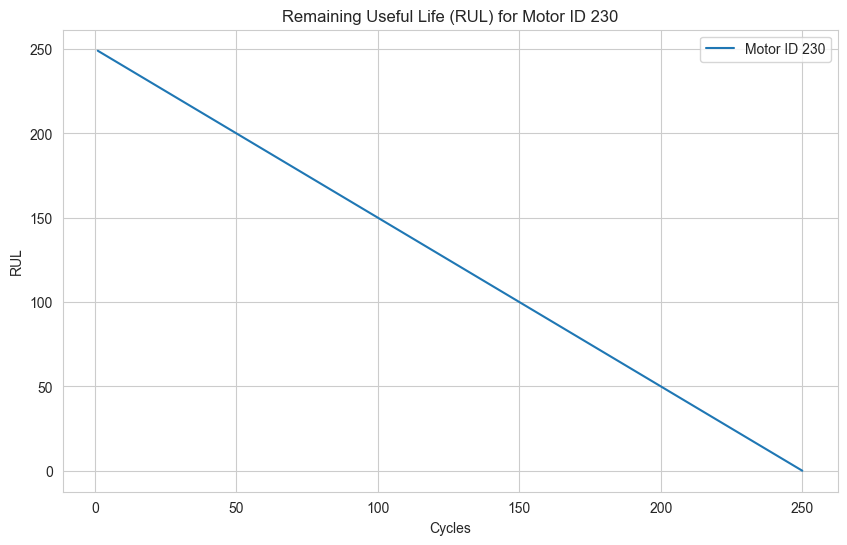

In [27]:
# Example motor ID
motor_id = 230
motor_data = turbine4_train[turbine4_train["unit_number"] == motor_id]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the RUL with "cycles" on the x-axis using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=motor_data, x="cycle", y="RUL", label=f'Motor ID {motor_id}')
plt.title(f'Remaining Useful Life (RUL) for Motor ID {motor_id}')
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.legend()
plt.show()

#### 1.4.3 Feature distributions

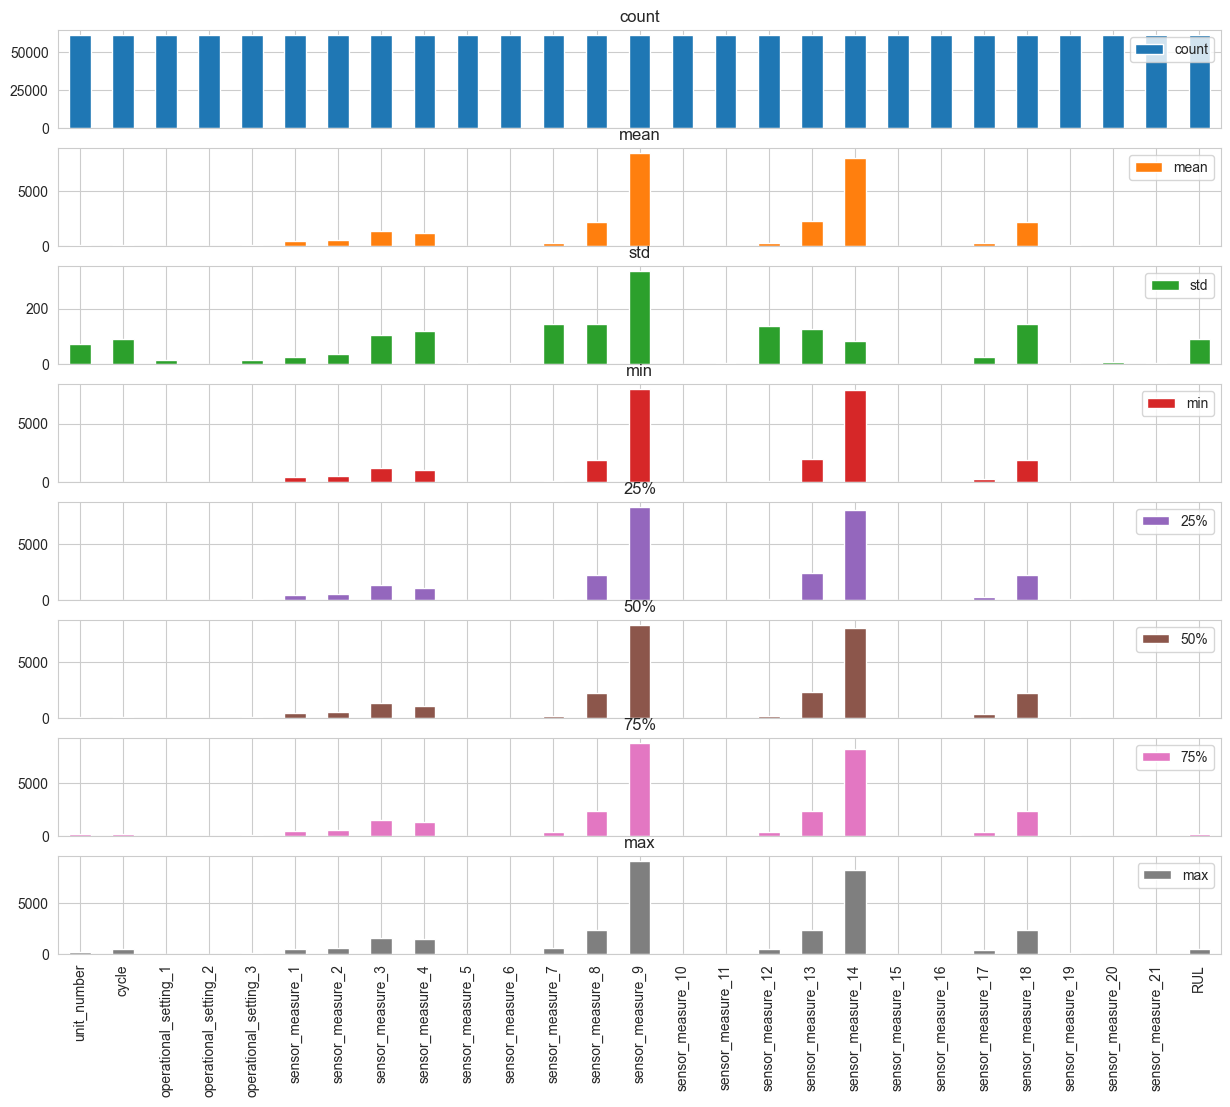

In [28]:
# plot an overview of whats going on in the columns
axes = turbine4_train.describe().T.plot.bar(subplots=True, figsize=(15,12))

It seems that there are columns with constant values.

In [29]:
cols_const = [ col for col in turbine4_train.columns if len(turbine4_train[col].unique()) <= 1 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')

Columns with constant values: 
[]



No there arent but if we search for only 2 unique values?

In [30]:
cols_const = [ col for col in turbine4_train.columns if len(turbine4_train[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')

cols_const = [ col for col in turbine4_test.columns if len(turbine4_test[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')

Columns with constant values: 
['operational_setting_3', 'sensor_measure_16', 'sensor_measure_19']

Columns with constant values: 
['operational_setting_3', 'sensor_measure_16', 'sensor_measure_19']



In train and test data they match.

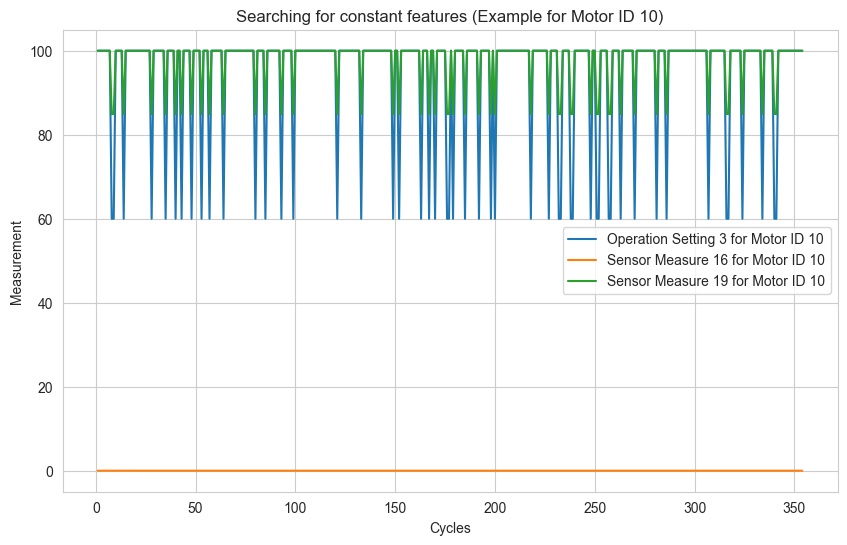

In [31]:
# Example motor ID
motor_id = 10
motor_data = turbine4_train[turbine4_train["unit_number"] == motor_id]

# Plot the RUL with "cycles" on the x-axis using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=motor_data, x="cycle", y="operational_setting_3", label=f'Operation Setting 3 for Motor ID {motor_id}')
sns.lineplot(data=motor_data, x="cycle", y="sensor_measure_16", label=f'Sensor Measure 16 for Motor ID {motor_id}')
sns.lineplot(data=motor_data, x="cycle", y="sensor_measure_19", label=f'Sensor Measure 19 for Motor ID {motor_id}')
plt.title(f'Searching for constant features (Example for Motor ID {motor_id})')
plt.xlabel('Cycles')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Ok, maybe could be useful eliminate this columns. We try with different motor id and th Sensor Measure 16 is always constan. Also the other two, Operation Setting 3 and Sensor Measure 19 have only two values and they are correlated.

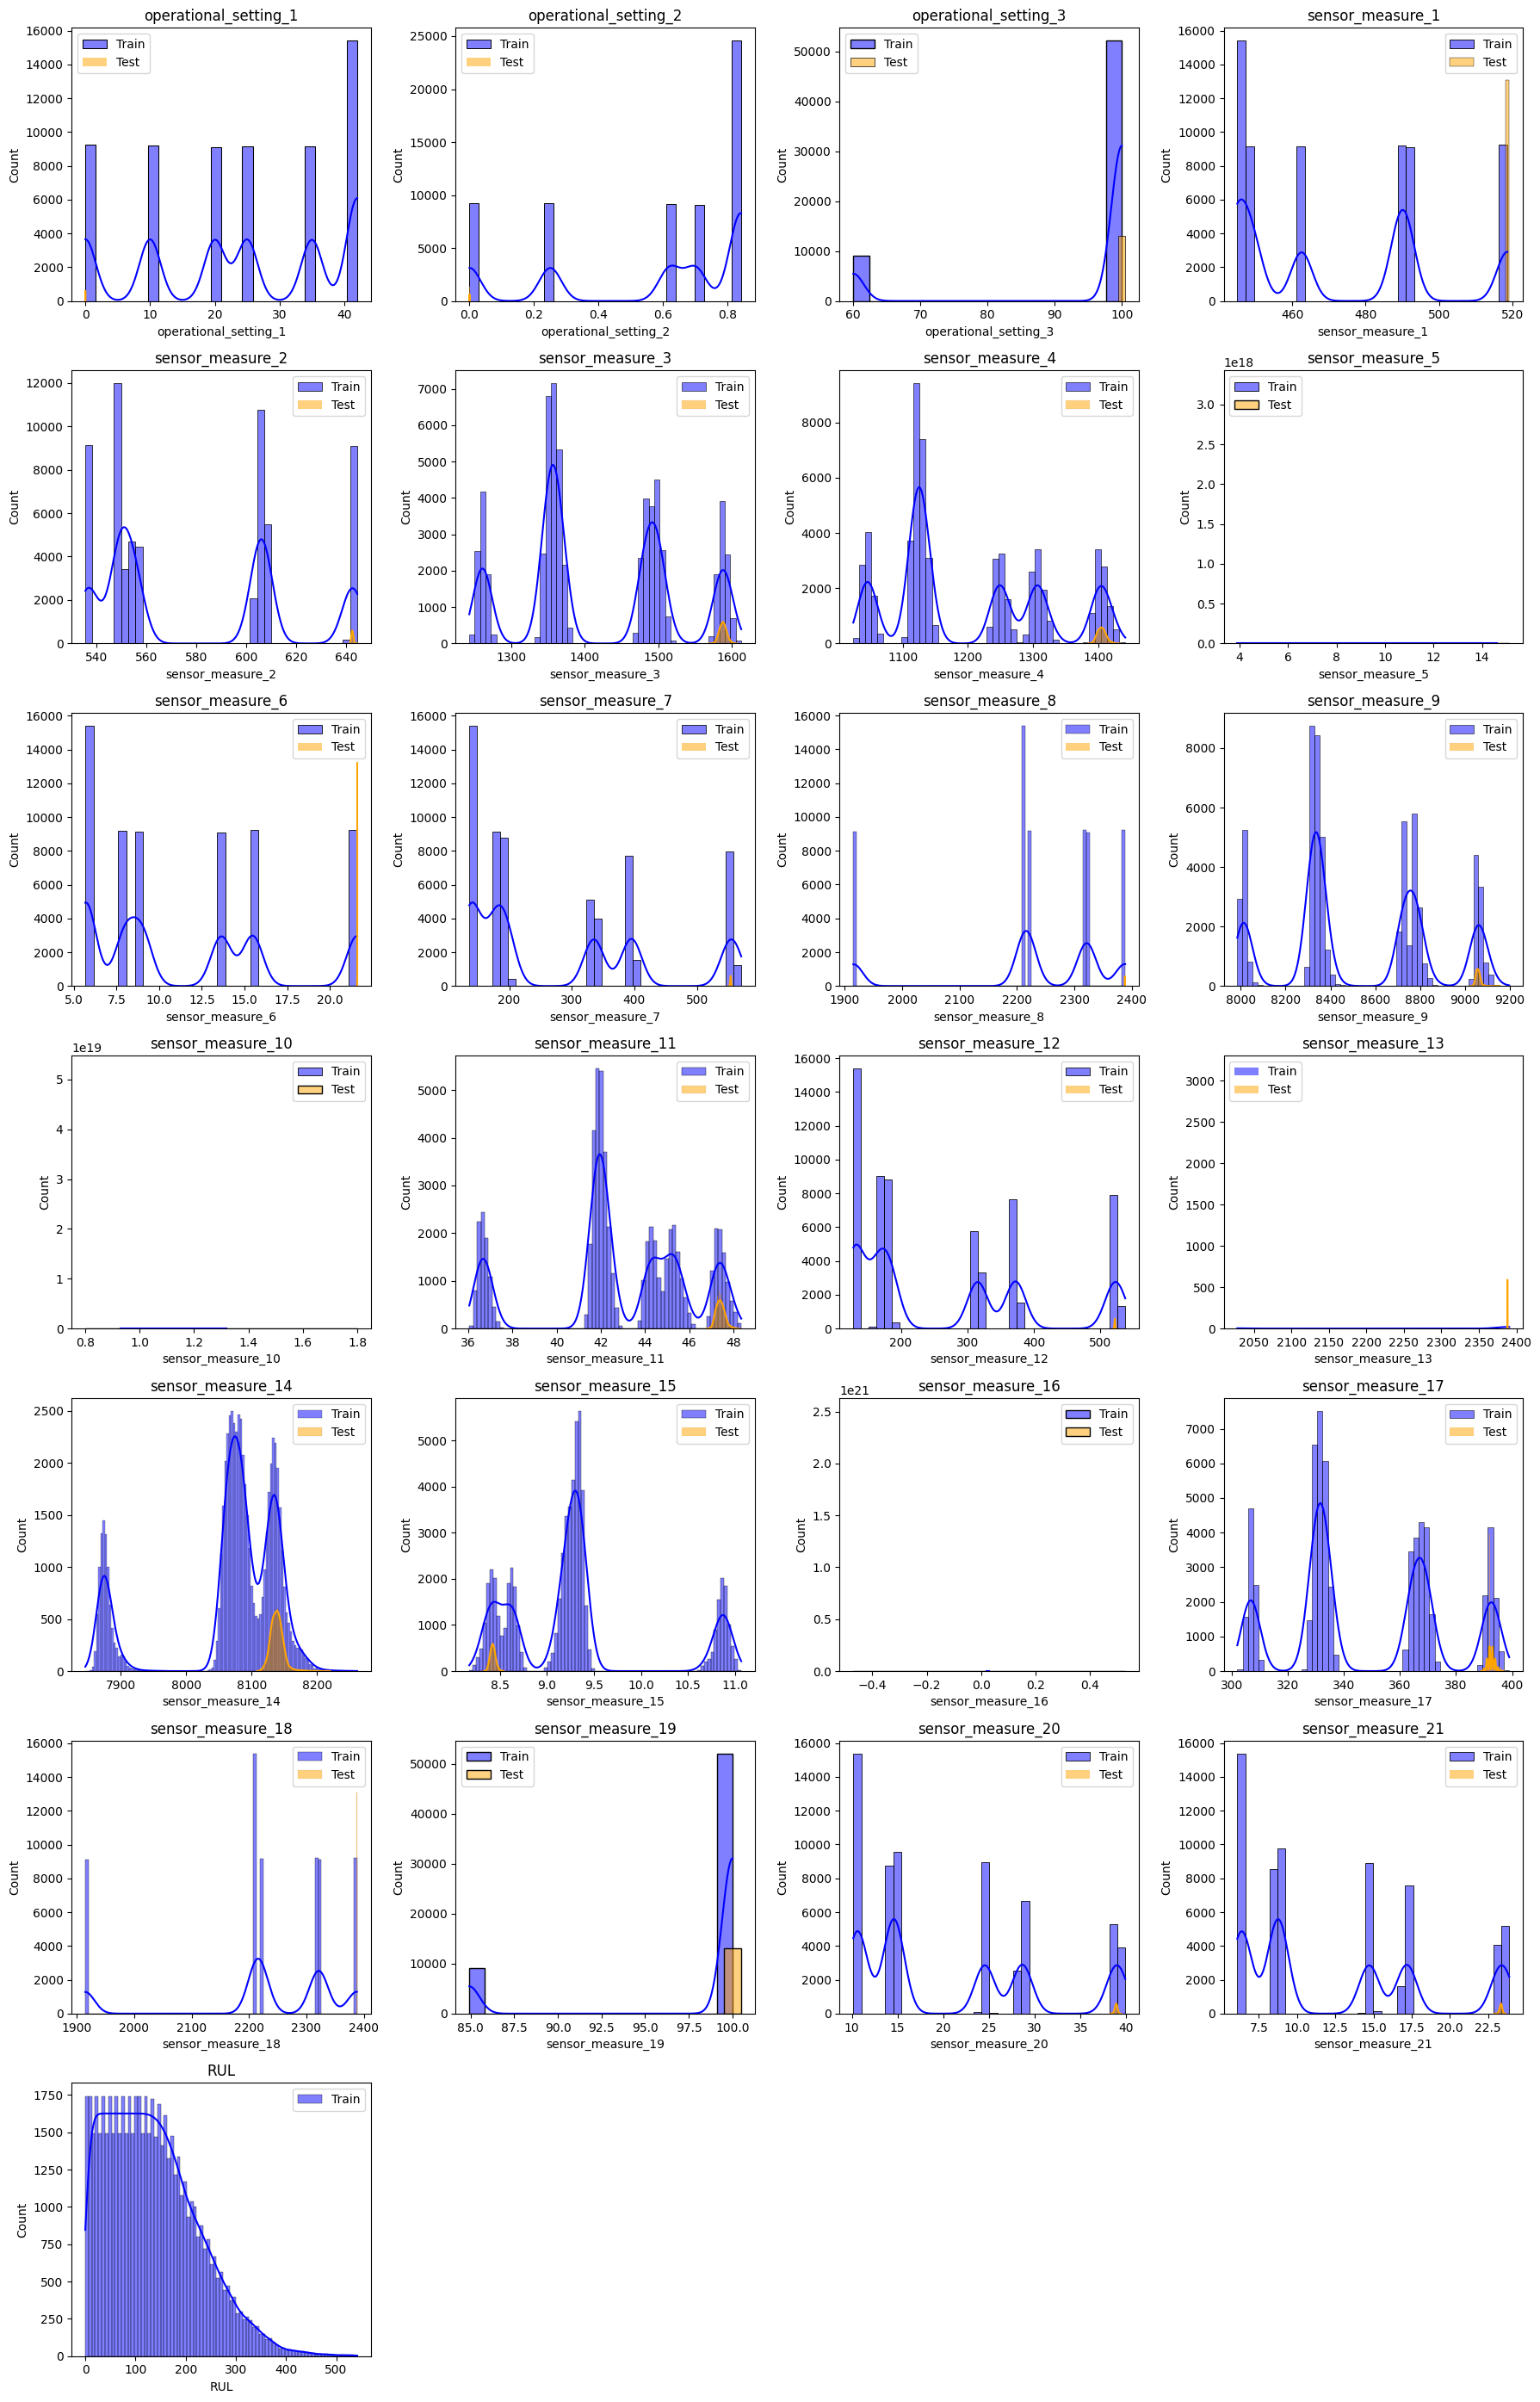

In [14]:
fig = plot_feature_distributuon(turbine4_train)

In [42]:
# save_plot(fig, 'feature_distribution_complete.svg')

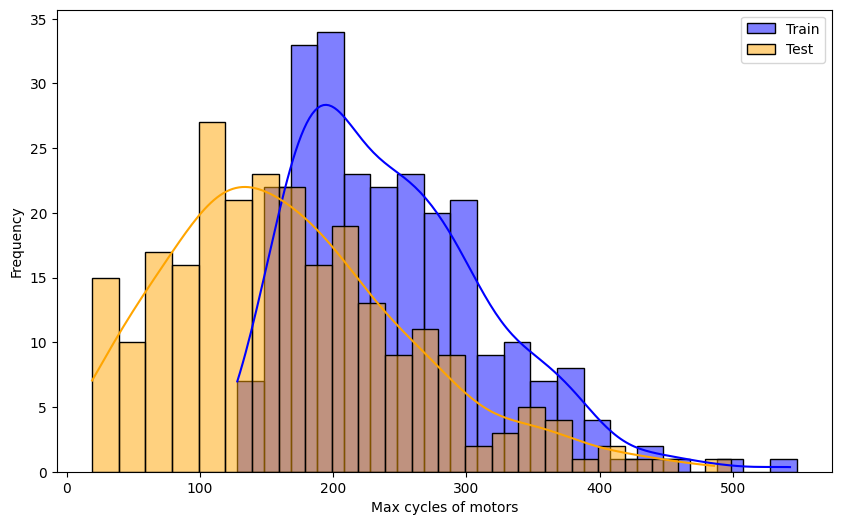

------------------------------
Maximum life cycle in the training set is : 543
Minimum life cycle in the training set is : 128
------------------------------
Maximum life cycle in the test set is : 486
Minimum life cycle in the test set is : 19


In [11]:
fig = count_train_test_cycle(turbine4_train, turbine4_test)

At first eye it is good that the train and test dataset have similar distributions form. The max cycle of test isnt real the max cycle, because in the test data the time line ends before the failure, but we can see a trend that is preserved in train and test data. The failure for train is around 200 cycles for the mean. The distribution is a bit skewed to the left. We have some outliers maschines that complete more than 400 cycles.

#### 1.4.4 Correlation

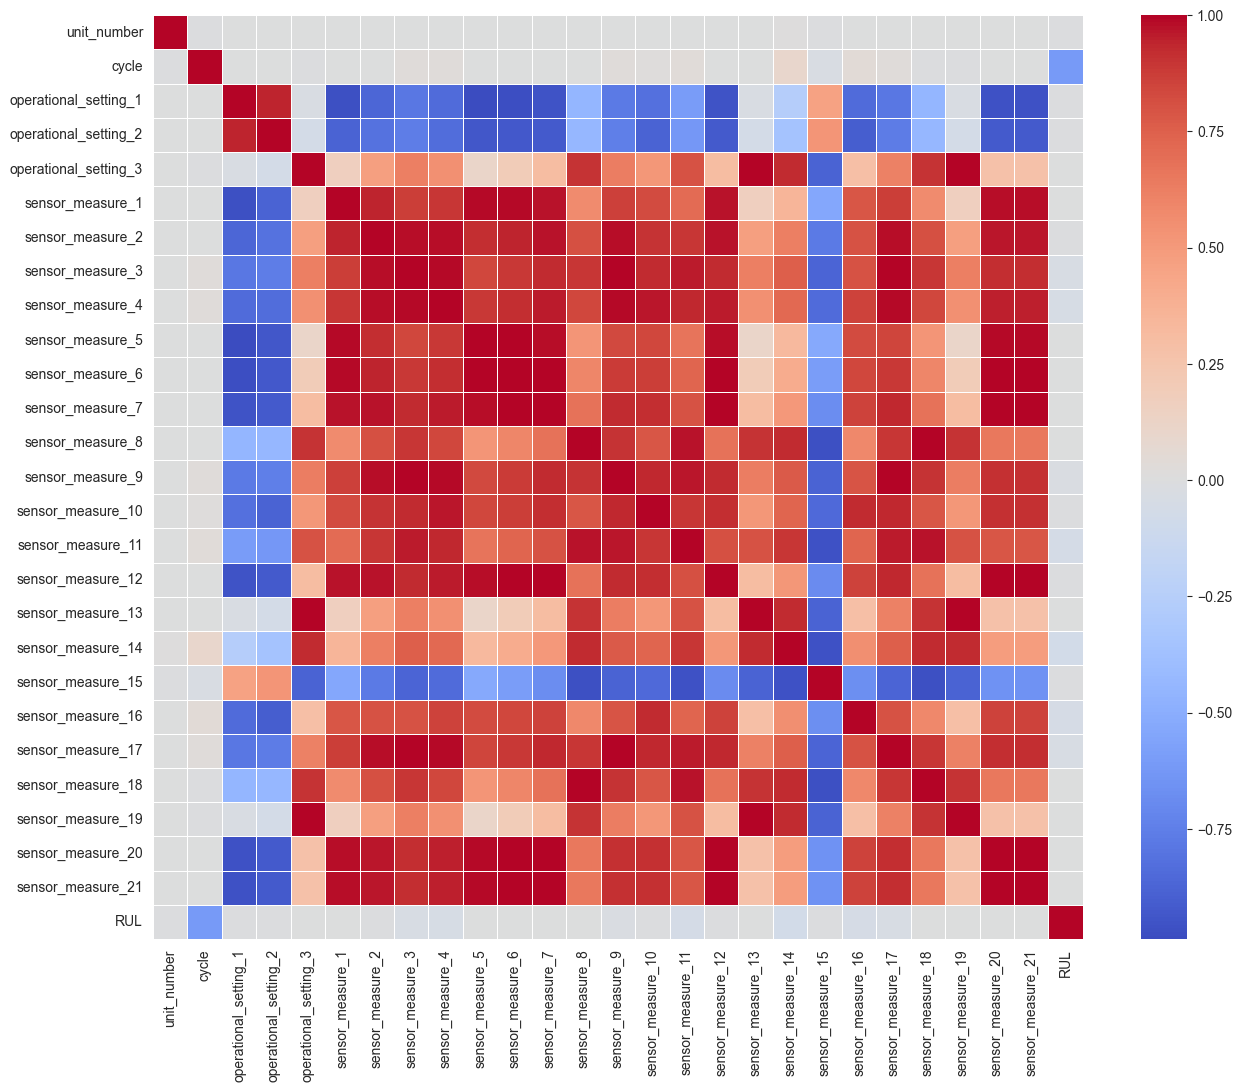

In [73]:
pearson_correlation_plot(turbine4_train)

In [40]:
high_corr_pairs = highly_correlated_values(turbine4_train)

Highly correlating values:
('operational_setting_1', 'operational_setting_2', 0.9437957915253659)
('operational_setting_1', 'sensor_measure_1', -0.9647537825551034)
('operational_setting_1', 'sensor_measure_2', -0.8683901310670603)
('operational_setting_1', 'sensor_measure_4', -0.8399879849209932)
('operational_setting_1', 'sensor_measure_5', -0.98738240721035)
('operational_setting_1', 'sensor_measure_6', -0.976518260435562)
('operational_setting_1', 'sensor_measure_7', -0.9515816690180171)
('operational_setting_1', 'sensor_measure_10', -0.823819118986815)
('operational_setting_1', 'sensor_measure_12', -0.9511577073510264)
('operational_setting_1', 'sensor_measure_16', -0.840823399514854)
('operational_setting_1', 'sensor_measure_20', -0.9620426253630363)
('operational_setting_1', 'sensor_measure_21', -0.9620518497410266)
('operational_setting_2', 'sensor_measure_1', -0.886122667495125)
('operational_setting_2', 'sensor_measure_2', -0.8116126104744334)
('operational_setting_2', 'senso

Maybe we can eliminate one of the high correlated features, the information is redundant. And the constant values of the previous part, maybe be can ignore it.

In [41]:
analysis_data_corr = turbine4_train.corr()
# Select the correlations with the target variable 'RUL'
rul_corr = analysis_data_corr['RUL']

# Sort the correlations by absolute value
sorted_rul_corr = rul_corr.reindex(rul_corr.abs().sort_values(ascending=False).index)

# Print the sorted correlating values with RUL
print('Correlating values with RUL, sorted by absolute value:')
for feature, correlation in sorted_rul_corr.items():
    print((feature, correlation))

Correlating values with RUL, sorted by absolute value:
('RUL', 1.0)
('cycle', -0.6106197186967642)
('sensor_measure_14', -0.07812615219035073)
('sensor_measure_11', -0.0566392400577737)
('sensor_measure_16', -0.053804336930271035)
('sensor_measure_4', -0.04588110859302568)
('sensor_measure_17', -0.032939303551029676)
('sensor_measure_3', -0.03292405654292328)
('sensor_measure_9', -0.02472715028406107)
('sensor_measure_10', -0.008924050245450826)
('sensor_measure_2', -0.004443240063718993)
('sensor_measure_15', -0.003957072898584357)
('unit_number', -0.003655914776624505)
('sensor_measure_20', 0.0028117009588077063)
('sensor_measure_21', 0.0027907932394577693)
('sensor_measure_18', 0.0027646377576236777)
('operational_setting_1', -0.0023803262557565495)
('operational_setting_3', 0.002303388225444186)
('sensor_measure_19', 0.002303388225443806)
('operational_setting_2', -0.0022795344868175756)
('sensor_measure_8', 0.002086059038859893)
('sensor_measure_1', 0.0018894117842805657)
('sensor

The correlation is minimal.

#### 1.4.5 Time and Distribution Plots

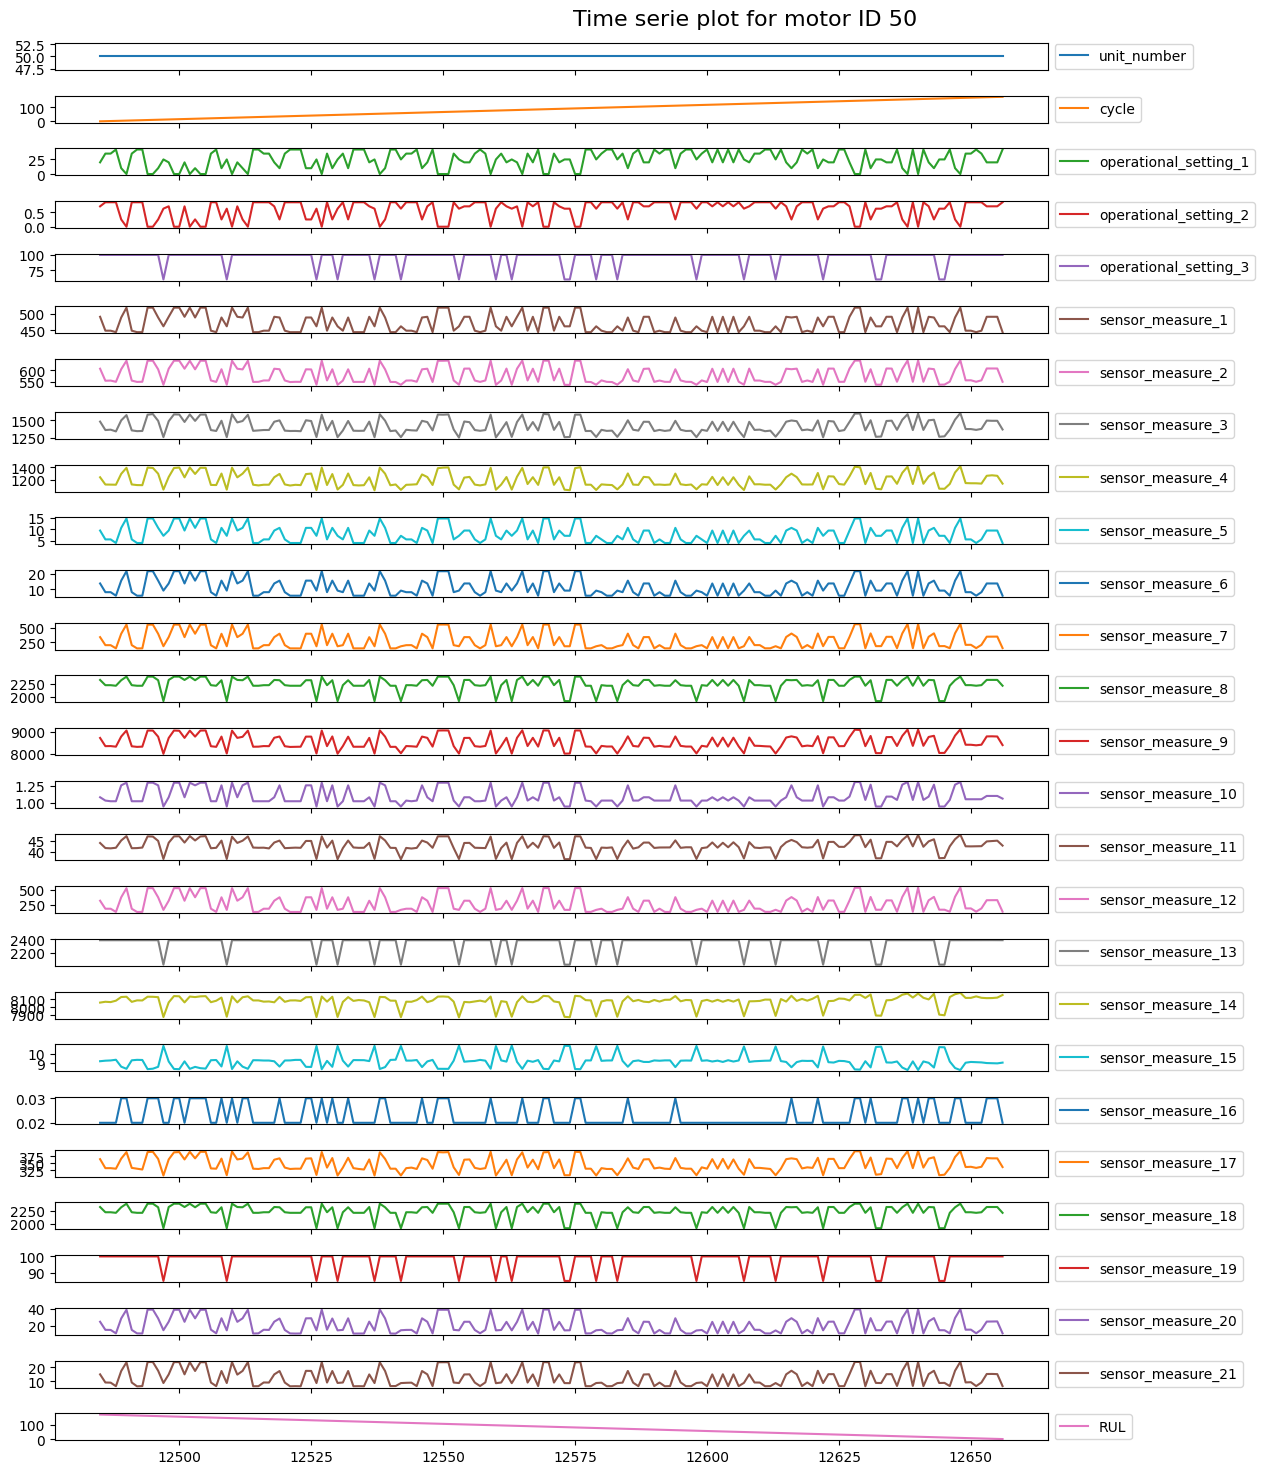

In [30]:
# Plot all sensor data of one motor
motor_id = 50

axes = turbine4_train[turbine4_train['unit_number']==motor_id].plot(subplots=True, figsize=(15, 15))
for ax in axes:
    # Set the legend to be outside the plot on the right
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 0.97])  # Make room on the right for the legends
plt.suptitle(f'Time serie plot for motor ID {motor_id}', fontsize=16)
fig = plt.gcf()
plt.show()

It is not easy to see a trend or something here. Lets se more in detail one motor feature.

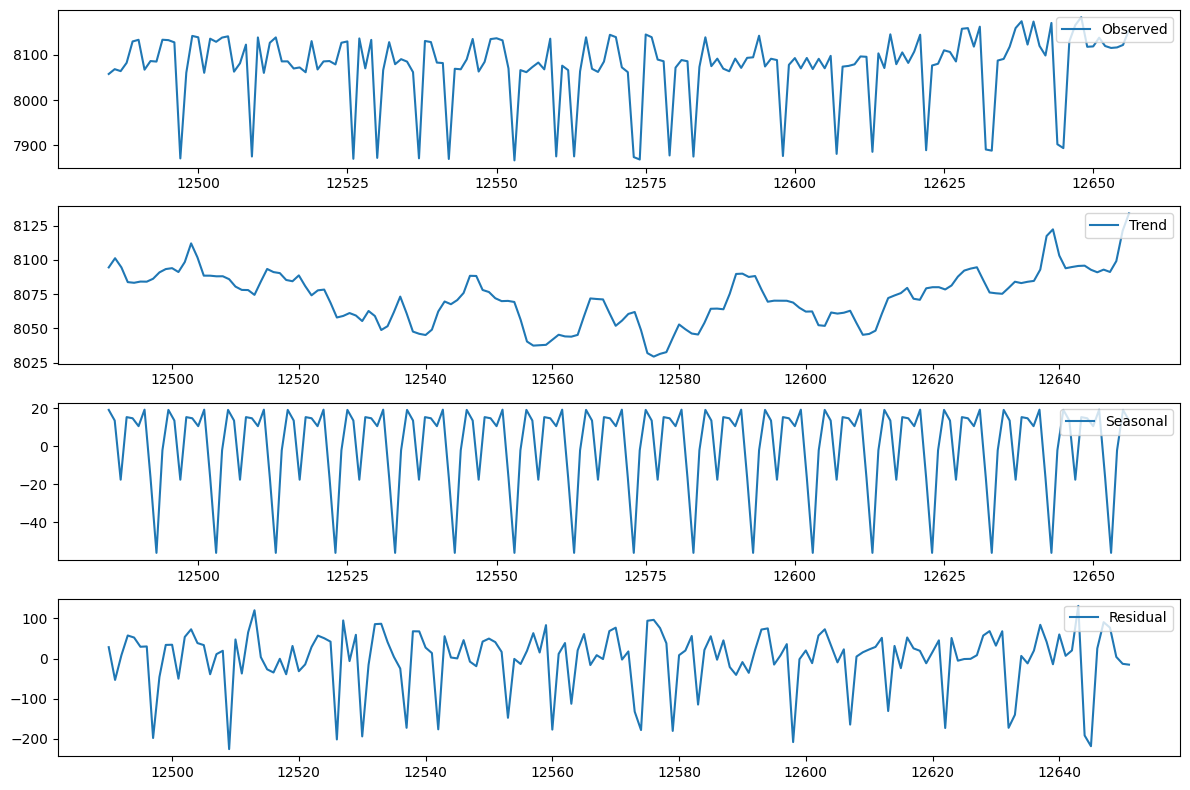

In [22]:
feature = 'sensor_measure_14' #Choose feature to see
motor_id = 50
ts = turbine4_train[turbine4_train['unit_number'] == motor_id][feature]

decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=10)
# Plot the decomposition components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ts, label='Observed')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper right')

plt.tight_layout()
fig = plt.gcf()
plt.show()

Now it is easier to see the trend of each sensor. Lets plot all sensor trends of one motor.

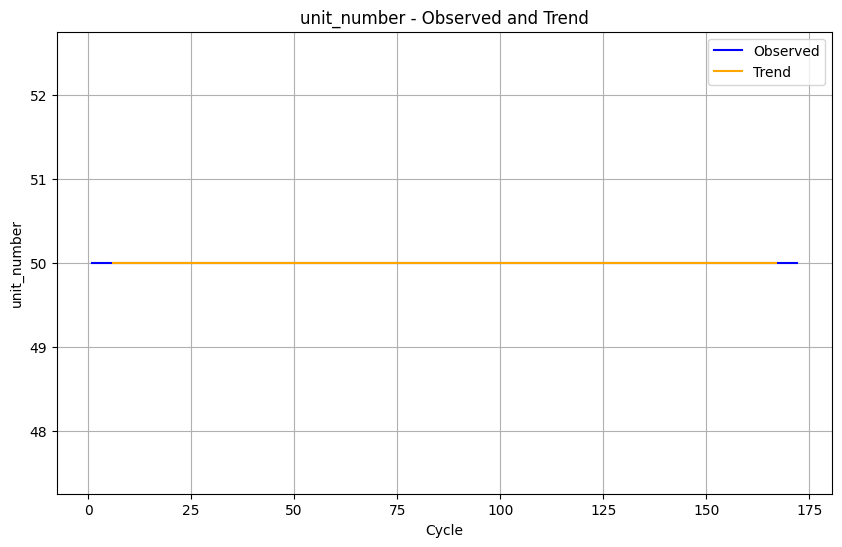

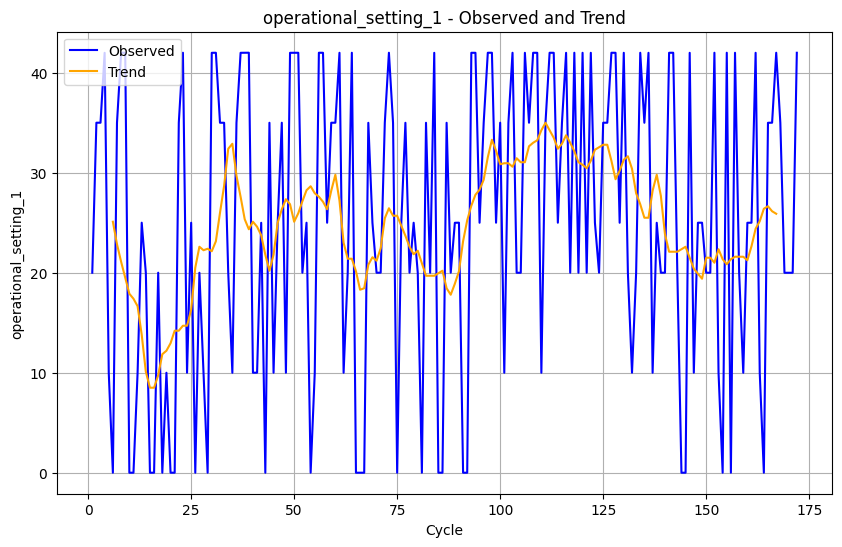

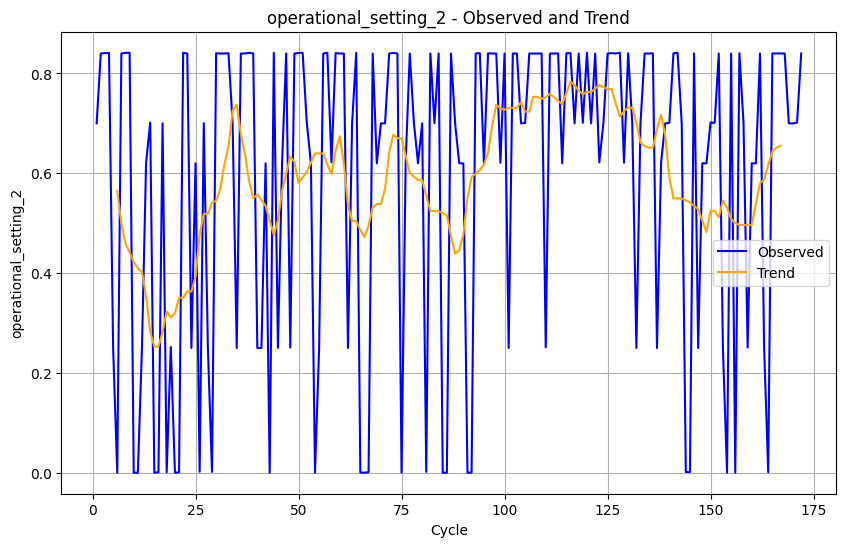

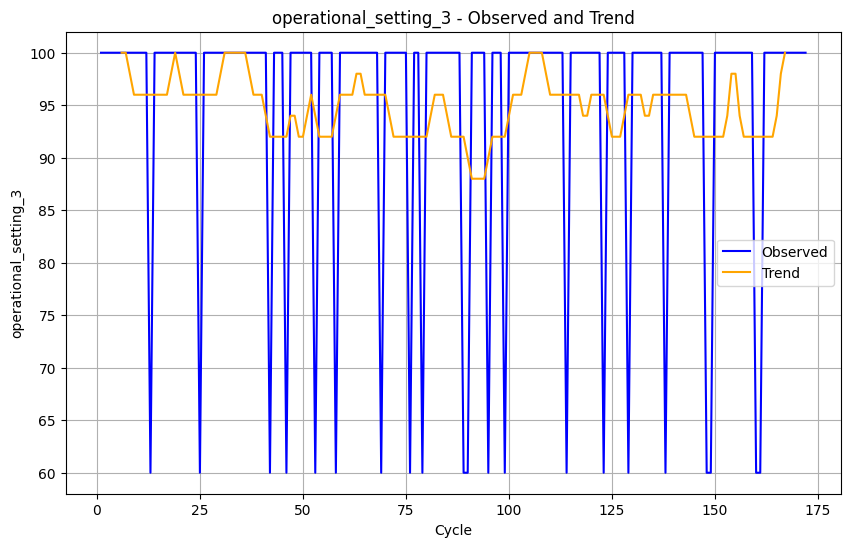

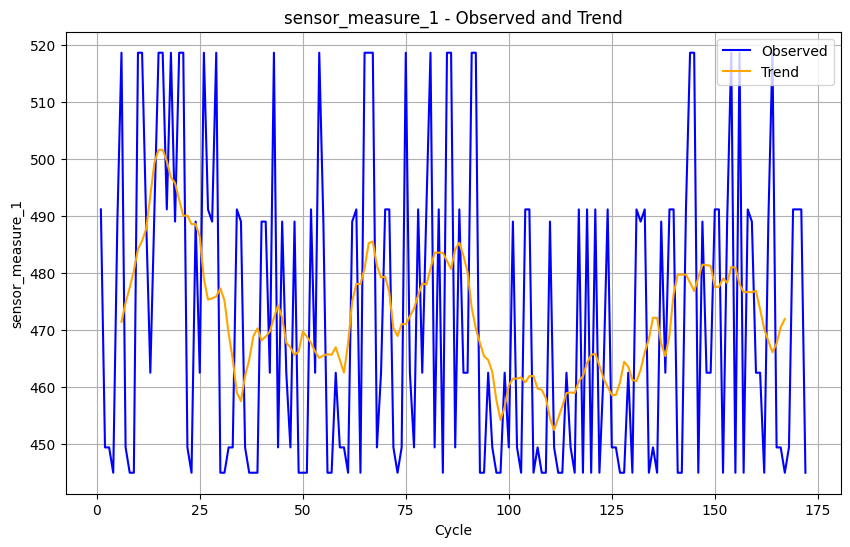

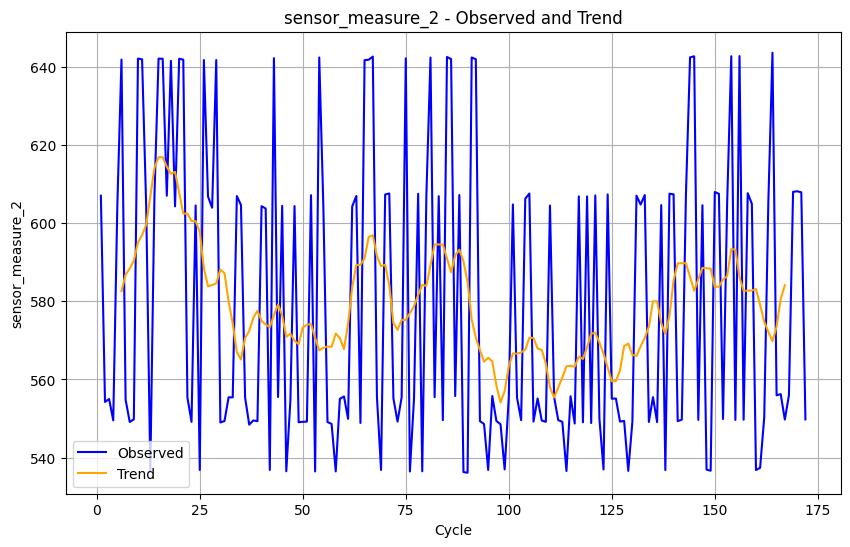

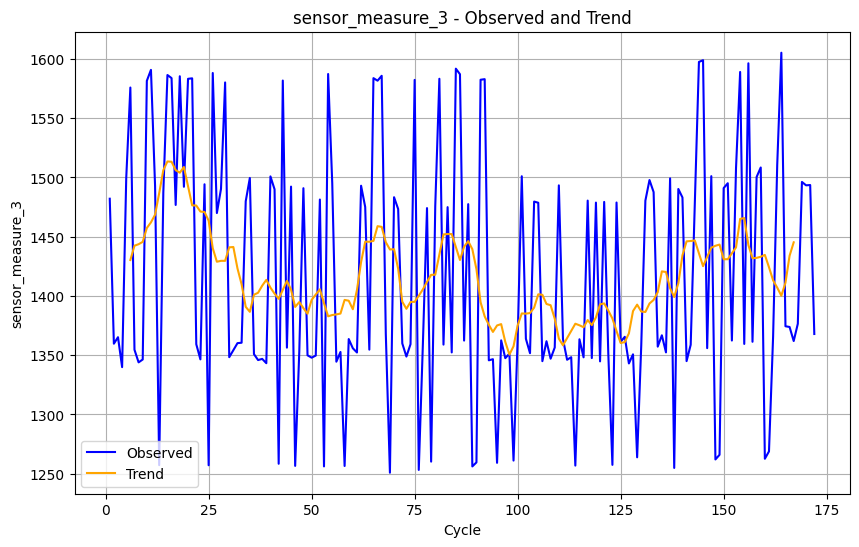

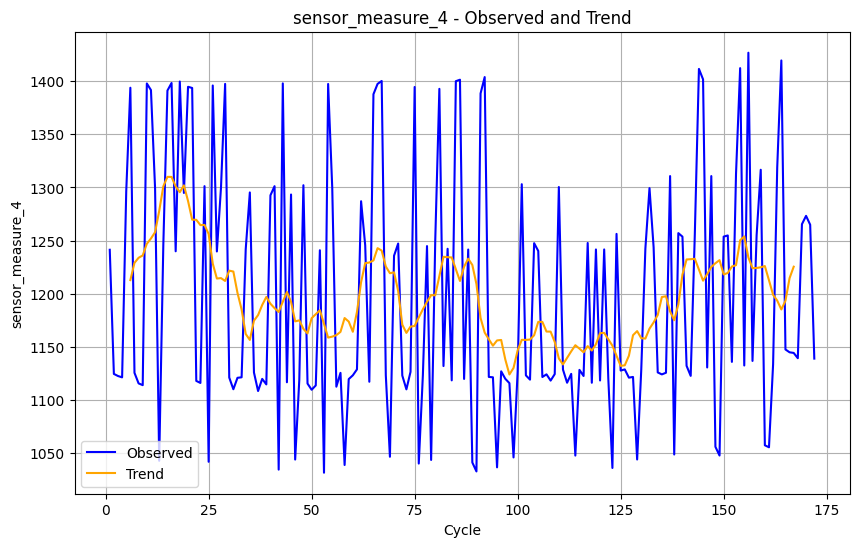

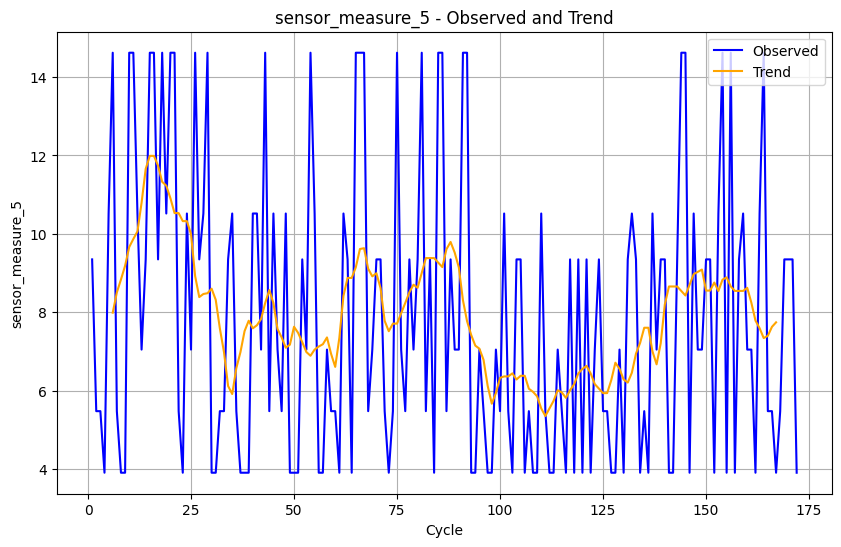

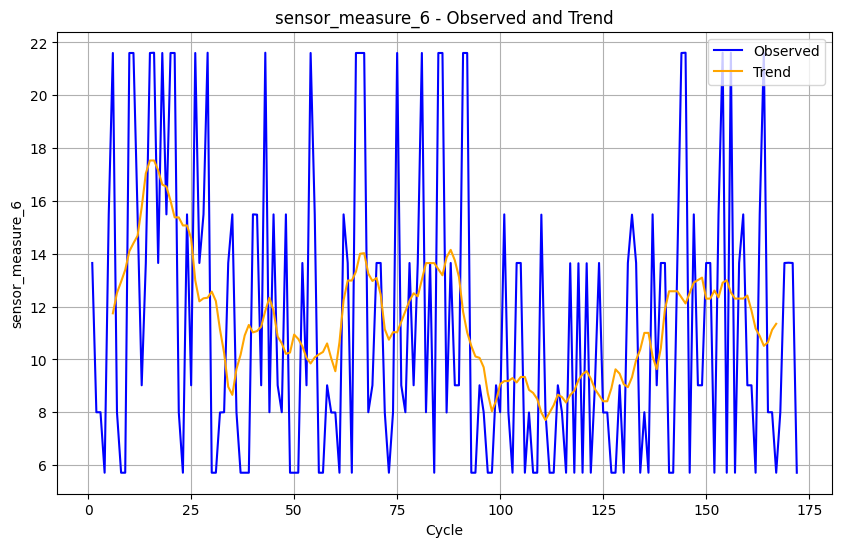

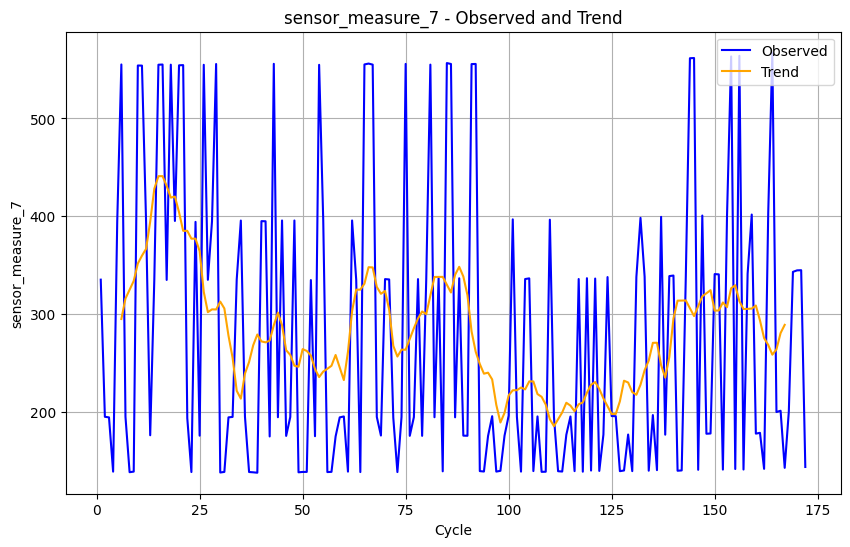

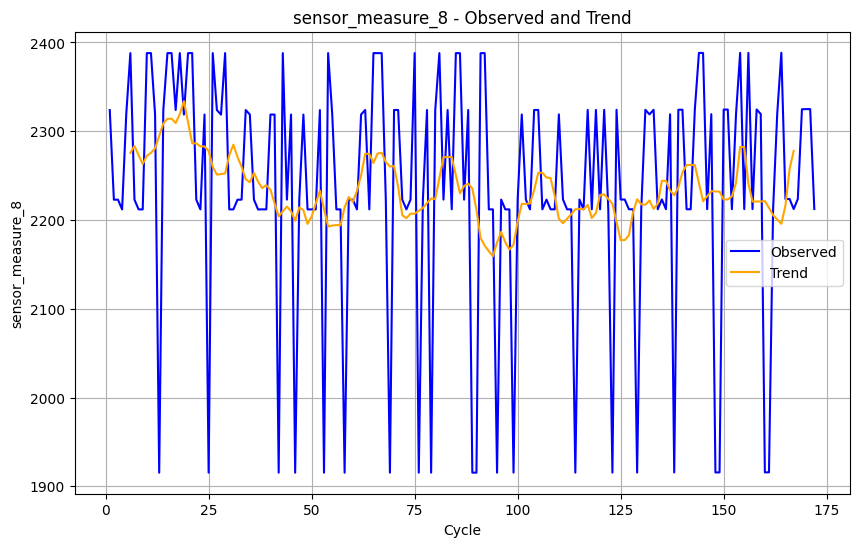

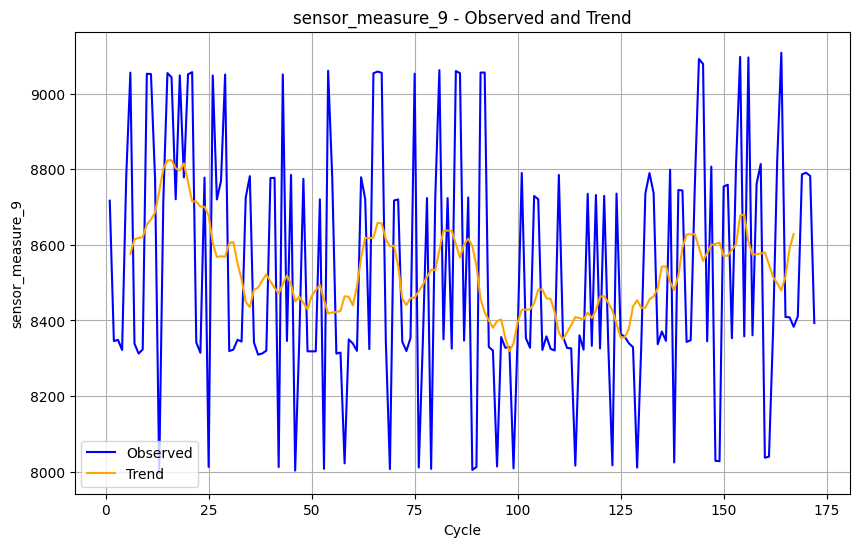

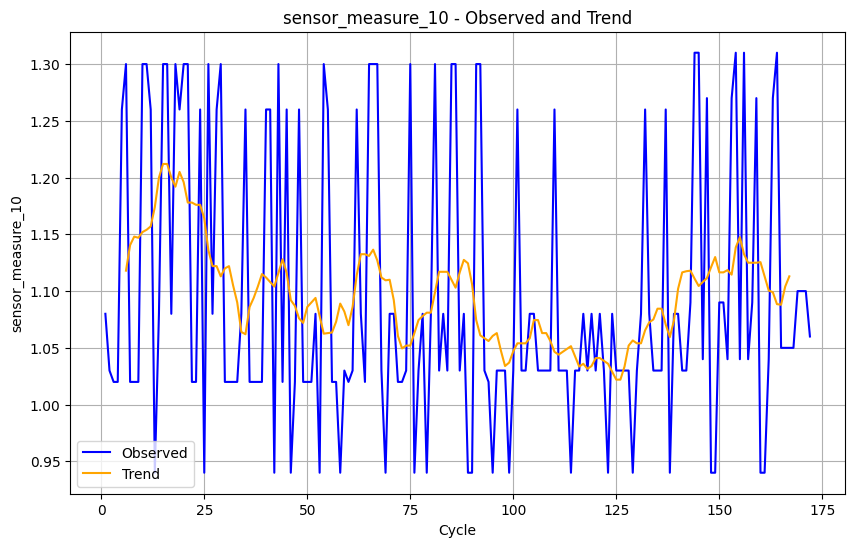

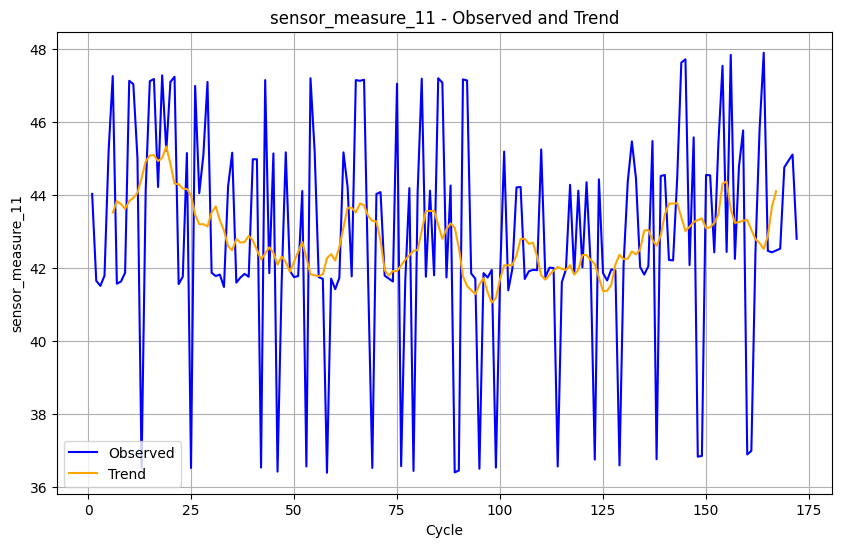

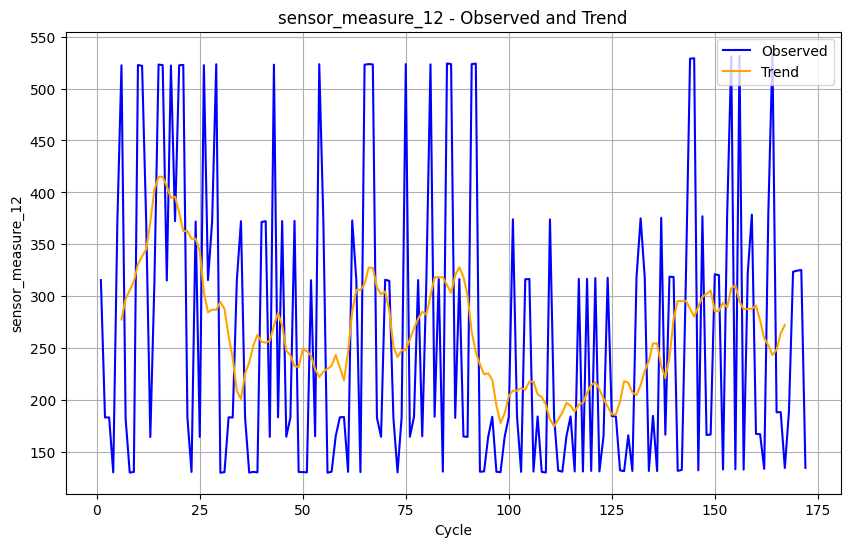

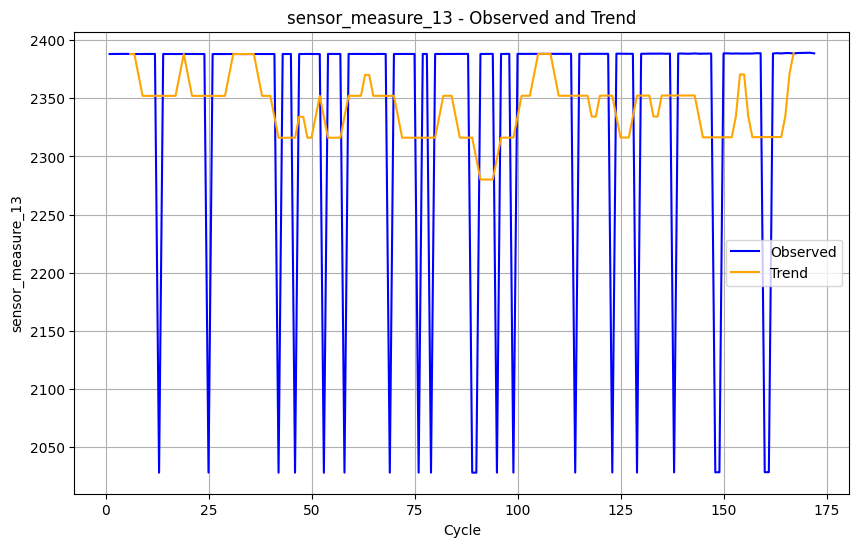

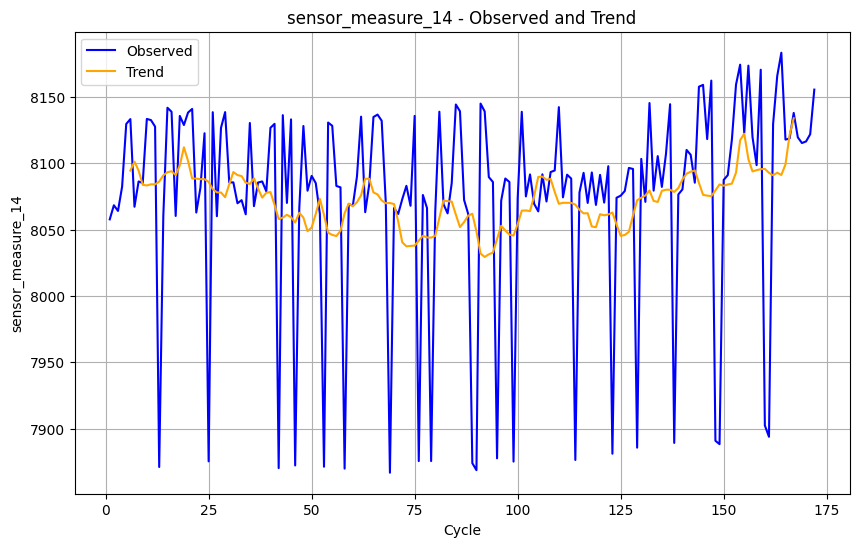

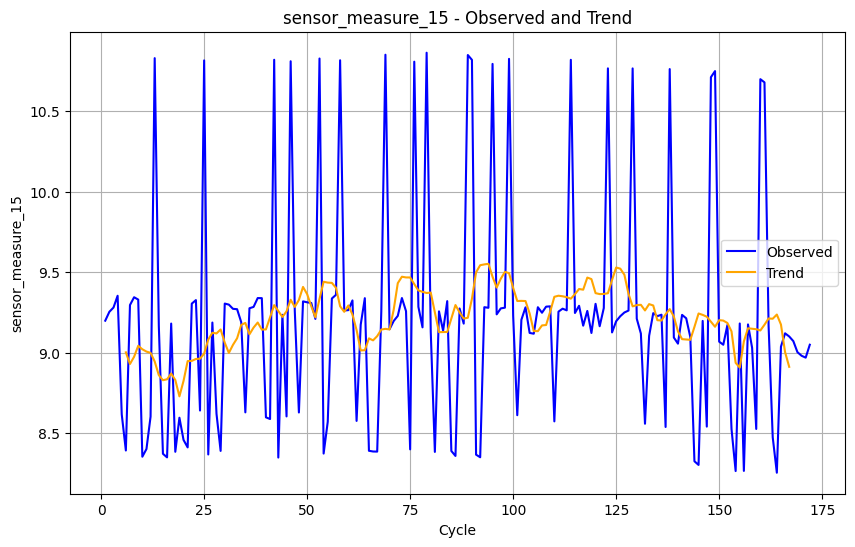

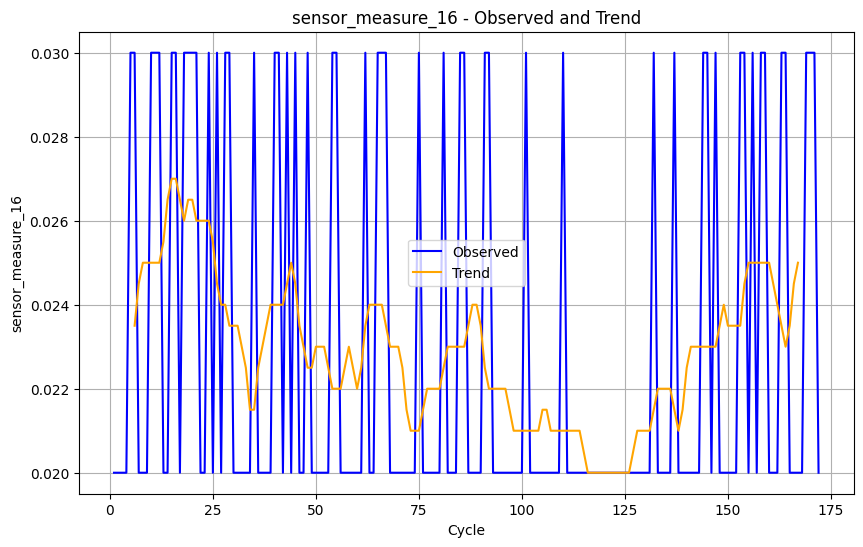

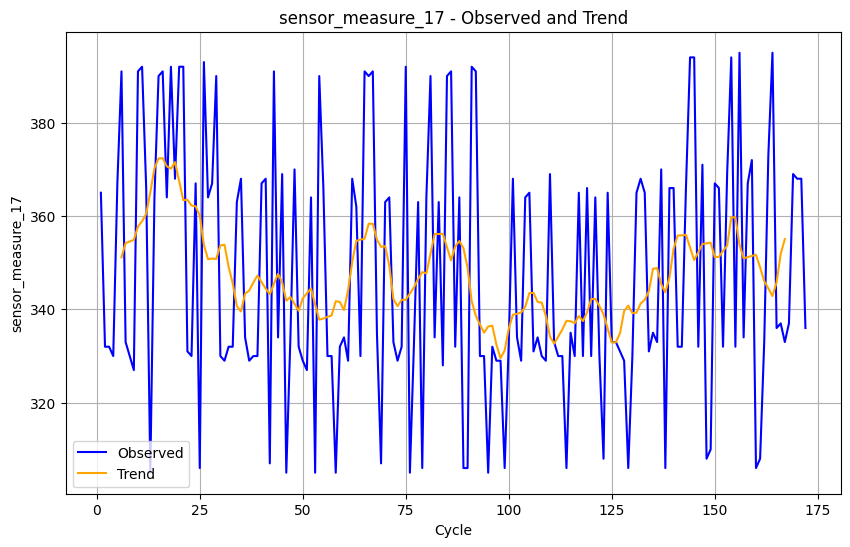

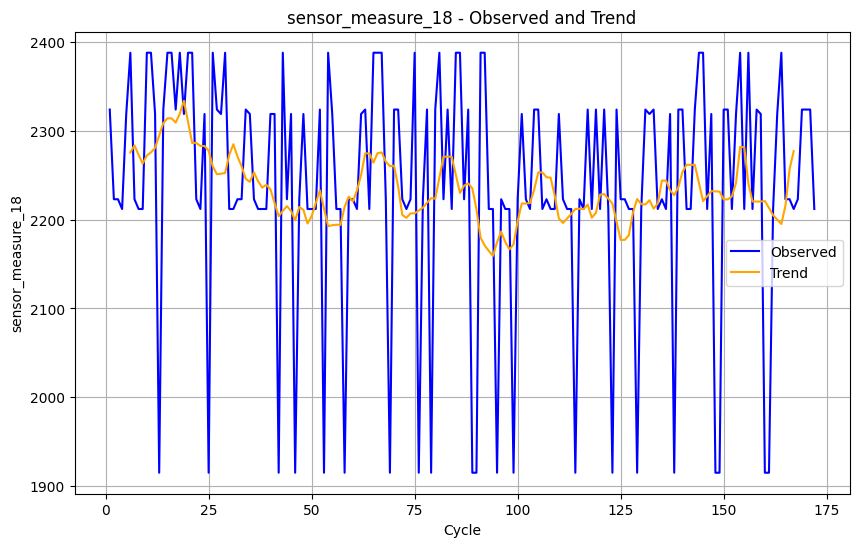

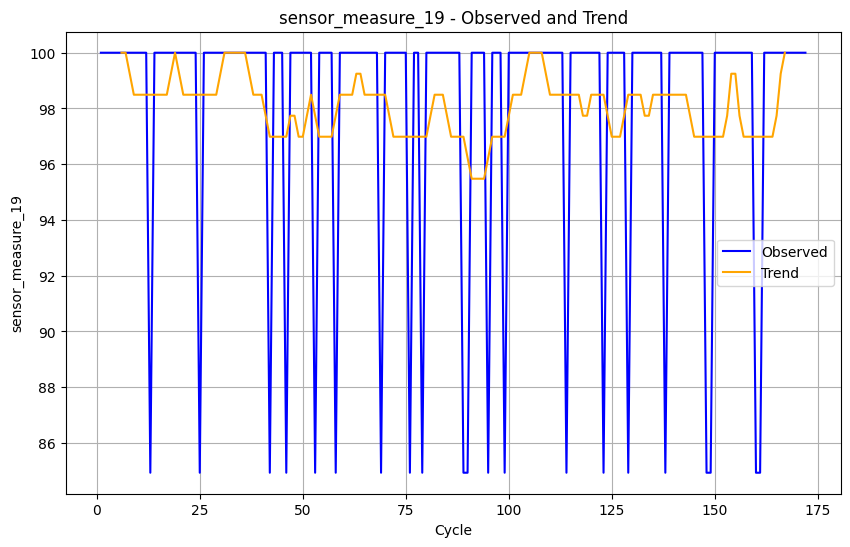

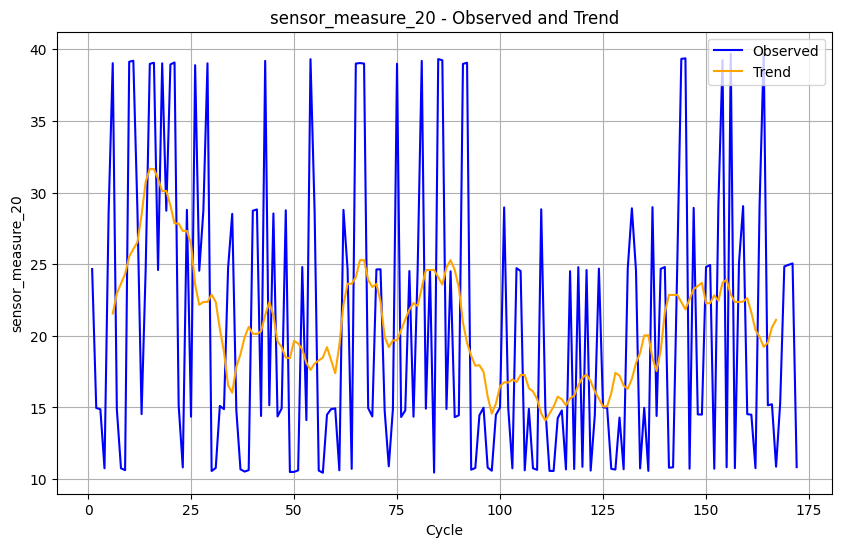

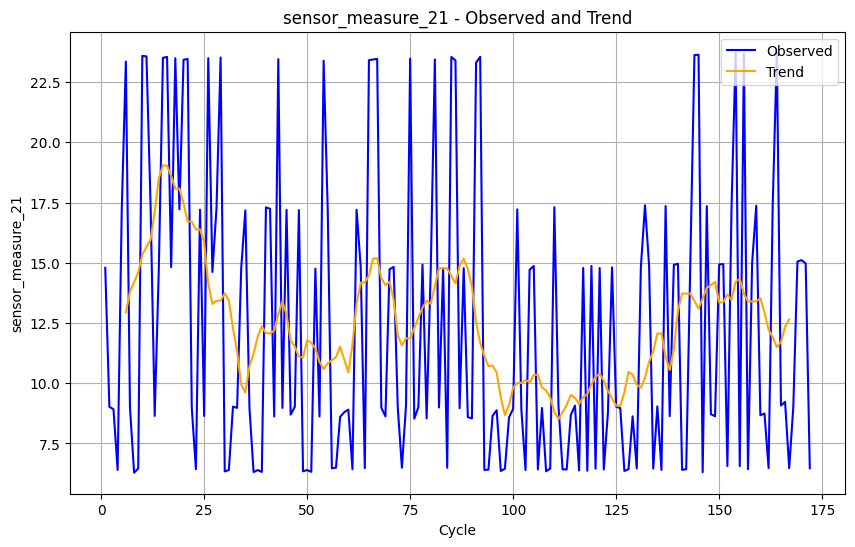

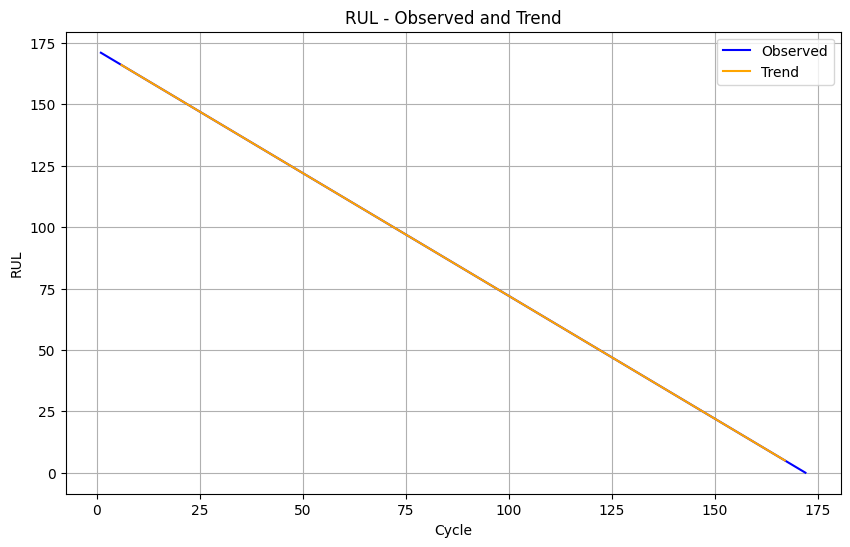

In [24]:
motor_id = 50
unit_data = turbine4_train[turbine4_train['unit_number'] == motor_id].set_index('cycle')
period = 10  # Adjust the period as needed

# Plot observed and trend data for each sensor column
for feature in unit_data.columns:
    ts = unit_data[feature]

    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=period)

    # Plot the observed and trend components
    plt.figure(figsize=(10, 6))
    plt.plot(ts, label='Observed', color='blue')
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.xlabel('Cycle')
    plt.ylabel(feature)
    plt.title(f'{feature} - Observed and Trend')
    plt.legend()
    plt.grid(True)
    plt.show()


It is not easy to say something. But we can see a trend that maybe a model can learn. Lets try to see some motors togeter

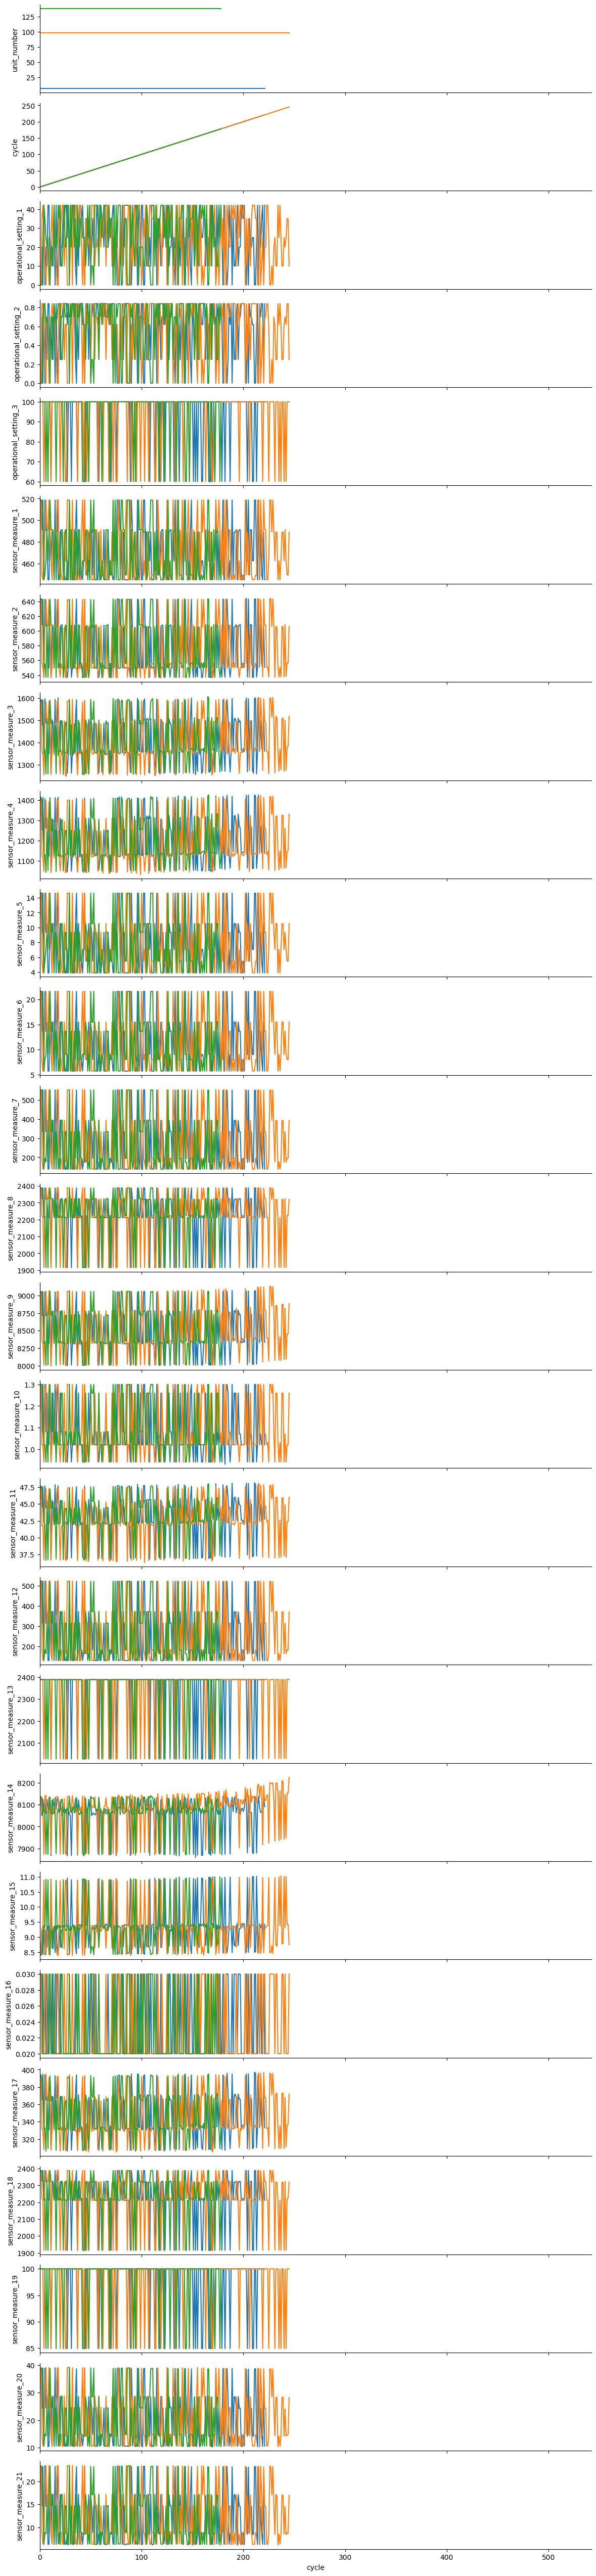

In [31]:
# Plot random 3 motors.
random_motor_ids = pd.Series(unit_train).sample(n=3, random_state=42).tolist()
filtered_data = turbine4_train[turbine4_train['unit_number'].isin(random_motor_ids)]
g = sns.PairGrid(data=filtered_data, x_vars='cycle', y_vars=input_file_column_names, hue="unit_number", height=2, aspect=6,)
g = g.map(plt.plot)
g = g.set(xlim=(turbine4_train['RUL'].min(), turbine4_train['RUL'].max()))

The tree time lines look very alike. But it is difficult to say something, they overlap a lot.

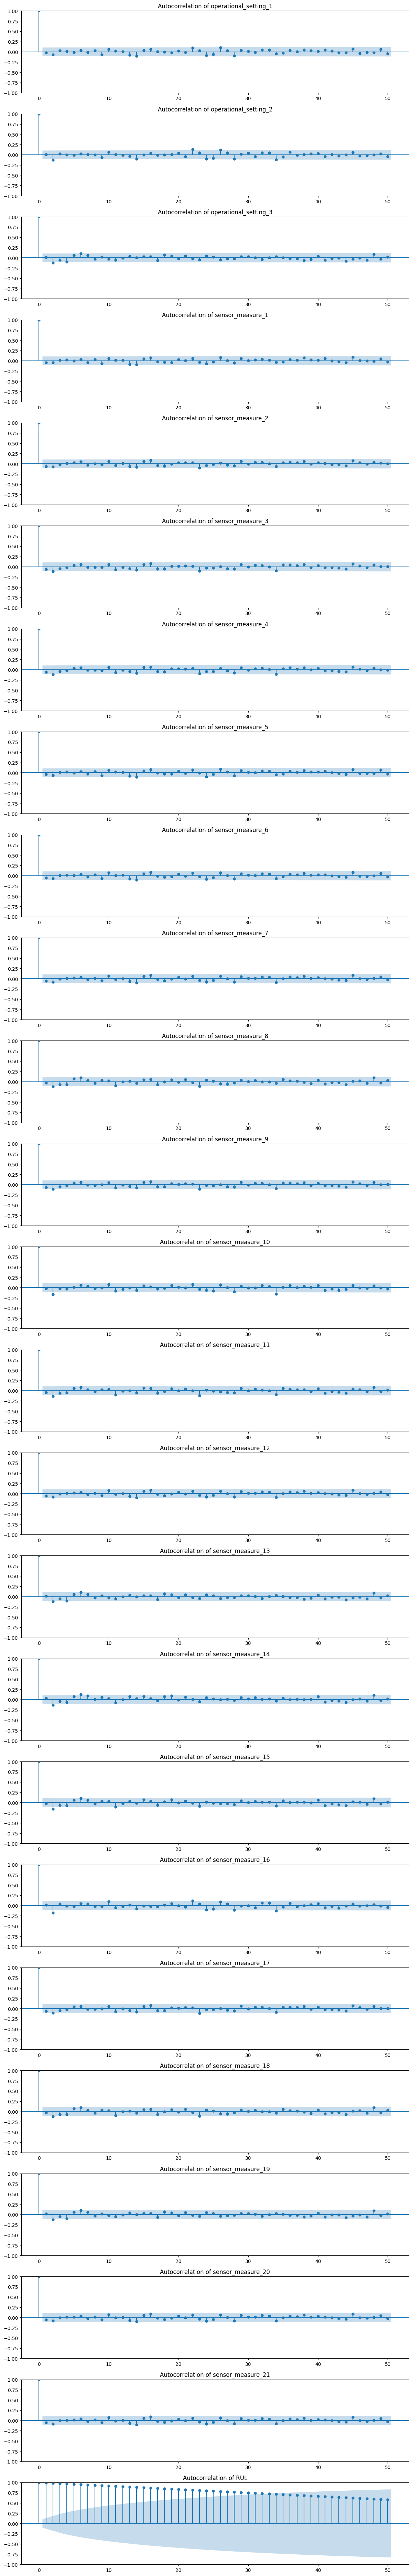

In [32]:
motor_id = 10  # Example unit_id, change as needed
unit_data = turbine4_train[turbine4_train['unit_number'] == motor_id].set_index('cycle')
unit_data = unit_data.drop(['unit_number'], axis=1)

# Create subplots for autocorrelation plots
num_data = len(unit_data.columns)
fig, axes = plt.subplots(nrows=num_data, ncols=1, figsize=(12, num_data * 3))

# Compute and plot autocorrelation for each sensor column
for ax, feature in zip(axes, unit_data.columns):
    ts = unit_data[feature]

    # Plot the autocorrelation function (ACF)
    sm.graphics.tsa.plot_acf(ts.dropna(), lags=50, ax=ax)
    ax.set_title(f'Autocorrelation of {feature}')

plt.tight_layout()
plt.show()


It is not so good, the autocorrelation is near 0 almost all the time, this tell that the data its pretty random.

## 2. Take aways

1. Turbine 1
    - no missing values
    - setting 3, sensor 1, sensor 5, sensor 10, sensor 16,  sensor 18, and sensor 19  are features with only constant values.  Sensor sensor 6 only has minimal variability and is mostly constant => can be removed
    - There are 7 highly correlated sensor pairs (correlation > 0.8 or < -0.8)
    - Some sensors have a strong correlation (> 0.5 o r< -0.5) to RUL
    - Most sensors show a strong trend toward end of lifetime when passing a RUL of around 125. The trend is either increasing or decreasing. However, for sensor 14 and sensor 9, there is no single trend  for all motor units (could be removed?)
2. Turbine 2
    - etc
3. Turbine 3
    - No missing values
    - Constant Values: Sensor 1, 5, 16, 18, 19
    - Operational settings have no specific impact, no big influence.
    - some highly correlated features with over 95% Correlation (7 and 12, 8 and 13, 9 and 14)
    - Most sensor show a clear trend before breakdown, increasing or decreasing. And some also show a high correlation to RUL. E.g. Sensor 2, 3 and 4 always increase before breakdown.
    - Especiall sensor 6 and 10 show some interesting patterns, that require feature engineering to use those patterns properly, but are complicated to interpret. Sensor 10 often goes up before breakdown, and sensor 6 often stops showing any varaince, 50 cycles before breakdown or so.
4. Turbine 4
    - No missing values
    - There are some features with constant values (1 and 2 values only). The feature operational setting 3 and sensor measure 19 have only two values, but they are strong correlated => eliminate one or both?
    - There are strong correlated features, we can discard some of them.
    - No correlation of features to RUL.
    - Max cycle distribution of train and test similar, good for generalization.
    - Plotting some motors we can see some minimal trend, but mostly it is random. Autocorrelation also confirm this randomness.